<!-- @format -->

# Unsupervised Learning Trading Strategy

- Download/Load SP500 stocks prices data.
- Calculate different features and indicators on each stock.
- Aggregate on monthly level and filter top 150 most liquid stocks.
- Calculate Monthly Returns for different time-horizons.
- Download Fama-French Factors and Calculate Rolling Factor Betas.
- For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
- For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
- Visualize Portfolio returns and compare to SP500 returns.


<!-- @format -->

# All Packages Needed:

- pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt


<!-- @format -->

## 1. Download/Load SP500 stocks prices data.


In [29]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-02-12'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-02-16 A        34.751160   37.080002   37.169998   36.400002   36.720001   
           AAL      36.998150   38.610001   38.770000   37.529999   38.130001   
           AAPL     22.086264   24.160000   24.212500   23.652500   23.754999   
           ABBV     37.911564   53.509998   53.869999   52.730000   53.439999   
           ABT      32.751865   37.990002   38.009998   37.119999   37.130001   
...                       ...         ...         ...         ...         ...   
2024-02-09 YUM     130.270004  130.270004  130.410004  129.320007  130.410004   
           ZBH     122.800003  122.800003  125.309998  121.169998  123.900002   
           ZBRA    253.089996  253.089996  253.770004  248.360001  248.360001   
           ZION     40.090000   40.090000   40.419998   39.450001   39.919998   
           ZTS     197.320007  197.320007  198.220001  195.589996  195.589996   

Price                   volume  
date       ticker               
2016-02-16 A         2903600.0  
           AAL       7147500.0  
           AAPL    196231600.0  
           ABBV      8313000.0  
           ABT       7960200.0  
...                        ...  
2024-02-09 YUM       1951300.0  
           ZBH       3355600.0  
           ZBRA       328600.0  
           ZION      2150200.0  
           ZTS       2234100.0  

[994585 rows x 6 columns]

<!-- @format -->

## 2. Calculate features and technical indicators for each stock.

- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volume


<!-- @format -->

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}


In [30]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2) / \
    2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(
    lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(
    lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(
    lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(
    lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 2])


def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())


df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)


def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:, 0]
    return macd.sub(macd.mean()).div(macd.std())


df['macd'] = df.groupby(level=1, group_keys=False)[
    'adj close'].apply(compute_macd)


df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-02-16 A        34.751160   37.080002   37.169998   36.400002   36.720001   
           AAL      36.998150   38.610001   38.770000   37.529999   38.130001   
           AAPL     22.086264   24.160000   24.212500   23.652500   23.754999   
           ABBV     37.911564   53.509998   53.869999   52.730000   53.439999   
           ABT      32.751865   37.990002   38.009998   37.119999   37.130001   
...                       ...         ...         ...         ...         ...   
2024-02-09 YUM     130.270004  130.270004  130.410004  129.320007  130.410004   
           ZBH     122.800003  122.800003  125.309998  121.169998  123.900002   
           ZBRA    253.089996  253.089996  253.770004  248.360001  248.360001   
           ZION     40.090000   40.090000   40.419998   39.450001   39.919998   
           ZTS     197.320007  197.320007  198.220001  195.589996  195.589996   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-02-16 A         2903600.0         -0.000954        NaN       NaN   
           AAL       7147500.0          0.000178        NaN       NaN   
           AAPL    196231600.0         -0.001776        NaN       NaN   
           ABBV      8313000.0         -0.045299        NaN       NaN   
           ABT       7960200.0         -0.005800        NaN       NaN   
...                        ...               ...        ...       ...   
2024-02-09 YUM       1951300.0          0.000035  53.141218  4.853137   
           ZBH       3355600.0          0.000534  52.295322  4.792101   
           ZBRA       328600.0          0.000095  52.704688  5.475266   
           ZION      2150200.0          0.000288  46.805501  3.657032   
           ZTS       2234100.0          0.000059  58.605434  5.223430   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-02-16 A            NaN       NaN       NaN       NaN     100.903467  
           AAL          NaN       NaN       NaN       NaN     264.444276  
           AAPL         NaN       NaN       NaN       NaN    4334.022855  
           ABBV         NaN       NaN       NaN       NaN     315.158830  
           ABT          NaN       NaN       NaN       NaN     260.711399  
...                     ...       ...       ...       ...            ...  
2024-02-09 YUM     4.873659  4.894181  0.523591 -0.157976     254.195859  
           ZBH     4.825681  4.859261 -0.058516  0.492214     412.067690  
           ZBRA    5.519531  5.563795 -0.031984 -0.268105      83.165373  
           ZION    3.750742  3.844453  0.504907 -0.685760      86.201518  
           ZTS     5.260251  5.297072  0.654457  0.277294     440.832628  

[994585 rows x 14 columns]

<!-- @format -->

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

- To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.


In [31]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-03-31 A           62.013610   37.347195         -0.001771  59.325716   
           AAL        298.909266   39.297958         -0.001005  49.946231   
           AAPL      3231.204772   24.908747         -0.003548  73.688023   
           ABBV       256.185604   40.469238         -0.045347  56.610970   
           ABT        229.241217   36.062408         -0.007947  71.538856   
...                          ...         ...               ...        ...   
2024-02-29 YUM        302.410823  130.270004          0.000035  53.141218   
           ZBH        271.995436  122.800003          0.000534  52.295322   
           ZBRA       101.607892  253.089996          0.000095  52.704688   
           ZION       179.254487   40.090000          0.000288  46.805501   
           ZTS        363.229458  197.320007          0.000059  58.605434   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-03-31 A       3.598942  3.632082  3.665222 -1.169167  0.144883  
           AAL     3.680381  3.717086  3.753792  0.048075  0.429549  
           AAPL    3.167556  3.215080  3.262603 -1.122058  0.068365  
           ABBV    3.690339  3.712900  3.735461 -1.015852 -0.060528  
           ABT     3.532534  3.575936  3.619339 -1.174864  0.345416  
...                     ...       ...       ...       ...       ...  
2024-02-29 YUM     4.853137  4.873659  4.894181  0.523591 -0.157976  
           ZBH     4.792101  4.825681  4.859261 -0.058516  0.492214  
           ZBRA    5.475266  5.519531  5.563795 -0.031984 -0.268105  
           ZION    3.657032  3.750742  3.844453  0.504907 -0.685760  
           ZTS     5.223430  5.260251  5.297072  0.654457  0.277294  

[47476 rows x 9 columns]

<!-- @format -->

- Calculate 5-year rolling average of dollar volume for each stocks before filtering.


In [32]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack(
    'ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby(
    'date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank'] < 150].drop(
    ['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-02-28 AAL      44.898853         -0.000264  50.168970  3.767394   
           AAPL     31.969772         -0.001850  84.344540  3.403955   
           ABBV     45.488480         -0.037405  53.680595  3.810368   
           ABT      39.848412         -0.006505  71.877196  3.624358   
           ACN     109.569916         -0.004939  63.223103  4.614227   
...                       ...               ...        ...       ...   
2024-02-29 VRTX    422.910004          0.000096  53.588041  6.035193   
           VZ       39.720001          0.000211  50.817850  3.666193   
           WFC      48.060001          0.000135  50.539431  3.851007   
           WMT     169.279999          0.000011  66.122700  5.073641   
           XOM     101.769997          0.000264  50.580884  4.571036   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2017-02-28 AAL     3.816059  3.864723  0.245387  0.096477  
           AAPL    3.465752  3.527550 -1.194805  0.185449  
           ABBV    3.829030  3.847692 -1.524265 -0.162958  
           ABT     3.679207  3.734055 -1.277500  0.659445  
           ACN     4.672869  4.731512 -1.110866  0.167035  
...                     ...       ...       ...       ...  
2024-02-29 VRTX    6.068754  6.102314  1.521645  0.494392  
           VZ      3.733280  3.800367  0.017802  1.131927  
           WFC     3.901508  3.952009 -0.262726  0.192023  
           WMT     5.112670  5.151700 -0.084073  1.723345  
           XOM     4.622067  4.673097  0.438162  0.333261  

[12665 rows x 8 columns]

<!-- @format -->

## 4. Calculate Monthly Returns for different time horizons as features.

- To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.


In [33]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                       upper=x.quantile(1-outlier_cutoff)))
                                .add(1)
                                .pow(1/lag)
                                .sub(1))
    return df


data = data.groupby(level=1, group_keys=False).apply(
    calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-02-28 AAL      52.977318         -0.000118  55.685245  3.875603   
           AAPL     42.226002         -0.001265  59.836138  3.615828   
           ABBV     88.056610         -0.034391  56.507230  4.420361   
           ABT      54.474926         -0.004361  55.823928  3.947487   
           ACN     146.918533         -0.003895  54.875647  4.932437   
...                       ...               ...        ...       ...   
2024-02-29 VRTX    422.910004          0.000096  53.588041  6.035193   
           VZ       39.720001          0.000211  50.817850  3.666193   
           WFC      48.060001          0.000135  50.539431  3.851007   
           WMT     169.279999          0.000011  66.122700  5.073641   
           XOM     101.769997          0.000264  50.580884  4.571036   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-02-28 AAL     3.945411  4.015218  1.371027  0.438702   0.000632   
           AAPL    3.704858  3.793888 -0.798027 -0.022465   0.068185   
           ABBV    4.480013  4.539666  1.932024  1.147051   0.032169   
           ABT     3.999472  4.051457 -0.607462 -0.048272  -0.029440   
           ACN     4.981648  5.030859 -0.518751  0.102140   0.001929   
...                     ...       ...       ...       ...        ...   
2024-02-29 VRTX    6.068754  6.102314  1.521645  0.494392  -0.024159   
           VZ      3.733280  3.800367  0.017802  1.131927  -0.062101   
           WFC     3.901508  3.952009 -0.262726  0.192023  -0.035521   
           WMT     5.112670  5.151700 -0.084073  1.723345   0.024387   
           XOM     4.622067  4.673097  0.438162  0.333261  -0.010116   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-02-28 AAL      0.022092   0.024888   0.033351   0.013426    0.013883  
           AAPL     0.028019   0.013390   0.015155   0.018521    0.023458  
           ABBV     0.098315   0.063744   0.076940   0.065844    0.050362  
           ABT      0.030620   0.024517   0.030254   0.033180    0.026397  
           ACN      0.025541   0.028460   0.036957   0.030116    0.024744  
...                      ...        ...        ...        ...         ...  
2024-02-29 VRTX     0.019496   0.060272   0.032858   0.030196    0.031853  
           VZ       0.035059   0.017601   0.027868   0.018418    0.007963  
           WFC     -0.008390   0.027690   0.028345   0.023835    0.004901  
           WMT      0.036229   0.029560   0.007345   0.016723    0.015955  
           XOM      0.008912  -0.003157  -0.013150   0.001473   -0.004244  

[10490 rows x 14 columns]

<!-- @format -->

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

- We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

- The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

- We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.


In [34]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                             'famafrench',
                             start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-02-28 AAL    -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.000632
           AAPL   -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.068185
           ABBV   -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.032169
           ABT    -0.0365  0.0032 -0.0104  0.0052 -0.0237  -0.029440
           ACN    -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.001929
...                   ...     ...     ...     ...     ...        ...
2023-12-31 VRTX    0.0485  0.0732  0.0494 -0.0307  0.0132   0.146783
           VZ      0.0485  0.0732  0.0494 -0.0307  0.0132  -0.016436
           WFC     0.0485  0.0732  0.0494 -0.0307  0.0132   0.103835
           WMT     0.0485  0.0732  0.0494 -0.0307  0.0132   0.016350
           XOM     0.0485  0.0732  0.0494 -0.0307  0.0132  -0.026864

[10200 rows x 6 columns]

<!-- @format -->

- Filter out stocks with less than 10 months of data.


In [35]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values(
    'ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-02-28 AAL    -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.000632
           AAPL   -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.068185
           ABBV   -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.032169
           ABT    -0.0365  0.0032 -0.0104  0.0052 -0.0237  -0.029440
           ACN    -0.0365  0.0032 -0.0104  0.0052 -0.0237   0.001929
...                   ...     ...     ...     ...     ...        ...
2023-12-31 VRTX    0.0485  0.0732  0.0494 -0.0307  0.0132   0.146783
           VZ      0.0485  0.0732  0.0494 -0.0307  0.0132  -0.016436
           WFC     0.0485  0.0732  0.0494 -0.0307  0.0132   0.103835
           WMT     0.0485  0.0732  0.0494 -0.0307  0.0132   0.016350
           XOM     0.0485  0.0732  0.0494 -0.0307  0.0132  -0.026864

[10160 rows x 6 columns]

<!-- @format -->

- Calculate Rolling Factor Betas.


In [36]:
betas = (factor_data.groupby(level=1,
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(
                                         x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-02-28 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-12-31 VRTX    0.360415  0.009107 -0.291635 -0.024355  0.716337
           VZ      0.441508 -0.657972  0.529771  0.182677 -0.222913
           WFC     1.028876  0.200398  1.979782 -0.295541 -1.477347
           WMT     0.515457  0.193584 -0.756220  0.638942  0.818294
           XOM     0.738111 -0.467806  1.071868  0.523563  0.308473

[10160 rows x 5 columns]

<!-- @format -->

- Join the rolling factors data to the main features dataframe.


In [37]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[
    factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10322 entries, (Timestamp('2018-02-28 00:00:00'), 'AAL') to (Timestamp('2024-02-29 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10322 non-null  float64
 1   rsi               10322 non-null  float64
 2   bb_low            10322 non-null  float64
 3   bb_mid            10322 non-null  float64
 4   bb_high           10322 non-null  float64
 5   atr               10322 non-null  float64
 6   macd              10322 non-null  float64
 7   return_1m         10322 non-null  float64
 8   return_2m         10322 non-null  float64
 9   return_3m         10322 non-null  float64
 10  return_6m         10322 non-null  float64
 11  return_9m         10322 non-null  float64
 12  return_12m        10322 non-null  float64
 13  Mkt-RF            10322 non-null  float64
 14  SMB               10322 non-null  float64
 15  HML        

<!-- @format -->

### At this point we have to decide on what ML model and approach to use for predictions etc.


<!-- @format -->

## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering

- You may want to initialize predefined centroids for each cluster based on your research.

- For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

- Then we will pre-define our centroids for each cluster.


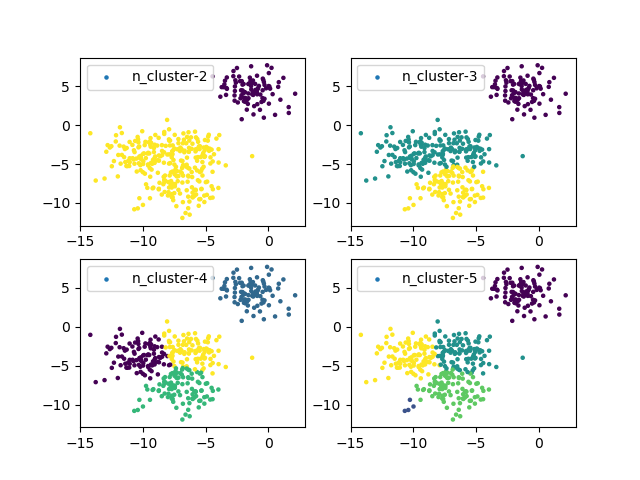

In [42]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [44]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)


def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df


data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-02-28 AAL            -0.000118  55.685245  3.875603  3.945411  4.015218   
           AAPL           -0.001265  59.836138  3.615828  3.704858  3.793888   
           ABBV           -0.034391  56.507230  4.420361  4.480013  4.539666   
           ABT            -0.004361  55.823928  3.947487  3.999472  4.051457   
           ACN            -0.003895  54.875647  4.932437  4.981648  5.030859   
...                             ...        ...       ...       ...       ...   
2024-02-29 VRTX            0.000096  53.588041  6.035193  6.068754  6.102314   
           VZ              0.000211  50.817850  3.666193  3.733280  3.800367   
           WFC             0.000135  50.539431  3.851007  3.901508  3.952009   
           WMT             0.000011  66.122700  5.073641  5.112670  5.151700   
           XOM             0.000264  50.580884  4.571036  4.622067  4.673097   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-02-28 AAL     1.371027  0.438702   0.000632   0.022092   0.024888   
           AAPL   -0.798027 -0.022465   0.068185   0.028019   0.013390   
           ABBV    1.932024  1.147051   0.032169   0.098315   0.063744   
           ABT    -0.607462 -0.048272  -0.029440   0.030620   0.024517   
           ACN    -0.518751  0.102140   0.001929   0.025541   0.028460   
...                     ...       ...        ...        ...        ...   
2024-02-29 VRTX    1.521645  0.494392  -0.024159   0.019496   0.060272   
           VZ      0.017802  1.131927  -0.062101   0.035059   0.017601   
           WFC    -0.262726  0.192023  -0.035521  -0.008390   0.027690   
           WMT    -0.084073  1.723345   0.024387   0.036229   0.029560   
           XOM     0.438162  0.333261  -0.010116   0.008912  -0.003157   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-02-28 AAL      0.033351   0.013426    0.013883  1.248158  1.381670   
           AAPL     0.015155   0.018521    0.023458  1.319628 -0.348839   
           ABBV     0.076940   0.065844    0.050362  0.462361  0.516135   
           ABT      0.030254   0.033180    0.026397  0.813787 -0.148129   
           ACN      0.036957   0.030116    0.024744  1.219930 -0.164422   
...                      ...        ...         ...       ...       ...   
2024-02-29 VRTX     0.032858   0.030196    0.031853  0.520243 -0.005268   
           VZ       0.027868   0.018418    0.007963  0.482672 -0.368462   
           WFC      0.028345   0.023835    0.004901  1.069541 -0.077662   
           WMT      0.007345   0.016723    0.015955  0.602887 -0.429727   
           XOM     -0.013150   0.001473   -0.004244  1.123614  0.258386   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-02-28 AAL     0.525158  0.248249  0.724392        2  
           AAPL   -0.615199  0.518405  0.588639        3  
           ABBV   -0.122216  0.444236  0.312288        2  
           ABT    -0.511381  0.296317  0.989926        2  
           ACN    -0.304769  0.311516  0.178392        2  
...                     ...       ...       ...      ...  
2024-02-29 VRTX   -0.893819  0.136899  0.859101        2  
           VZ      0.111603  0.284909  0.424477        1  
           WFC     1.473987 -0.723704 -0.667239        1  
           WMT    -0.321961  0.312827  0.687653        3  
           XOM     0.715479 -0.481639  0.604943        1  

[10322 rows x 19 columns]

In [49]:
def plot_clusters(data):

    cluster_0 = data[data['cluster'] == 0]
    cluster_1 = data[data['cluster'] == 1]
    cluster_2 = data[data['cluster'] == 2]
    cluster_3 = data[data['cluster'] == 3]

    plt.scatter(cluster_0.iloc[:, 5], cluster_0.iloc[:,
                1], color='red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:, 5], cluster_1.iloc[:,
                1], color='green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:, 5], cluster_2.iloc[:,
                1], color='blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:, 5], cluster_3.iloc[:,
                1], color='black', label='cluster 3')

    plt.legend()
    plt.show()
    return

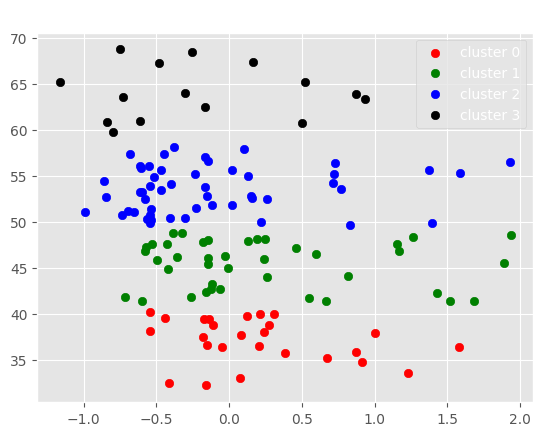

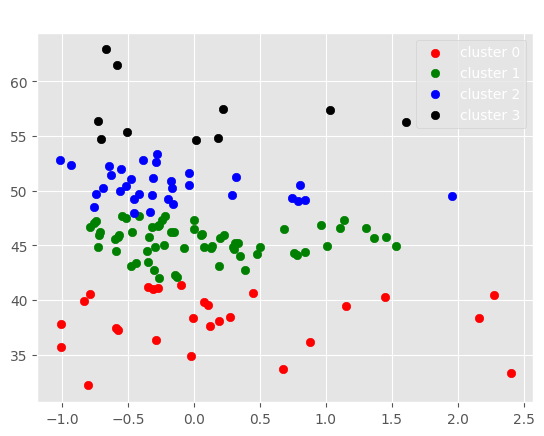

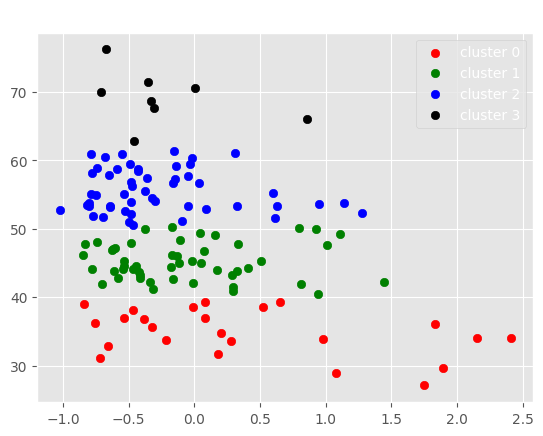

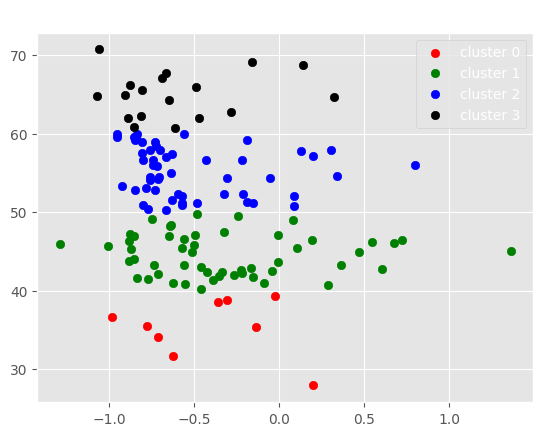

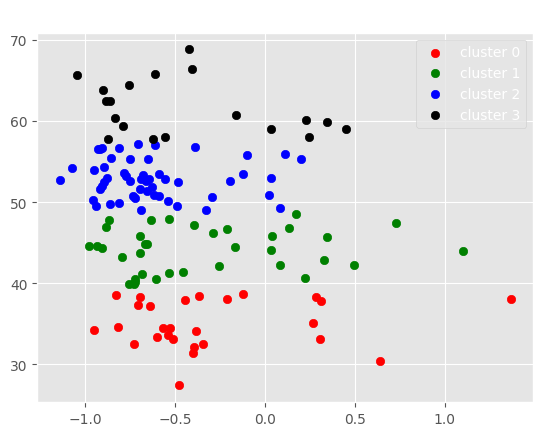

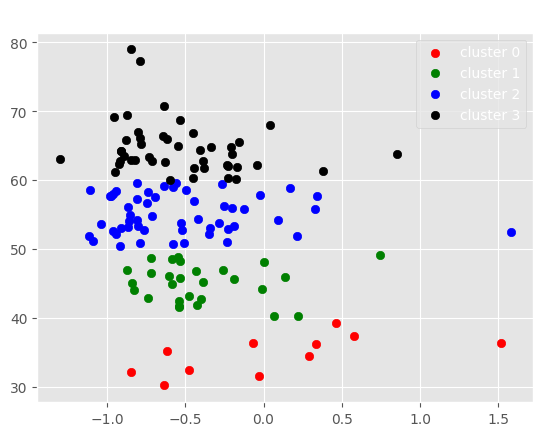

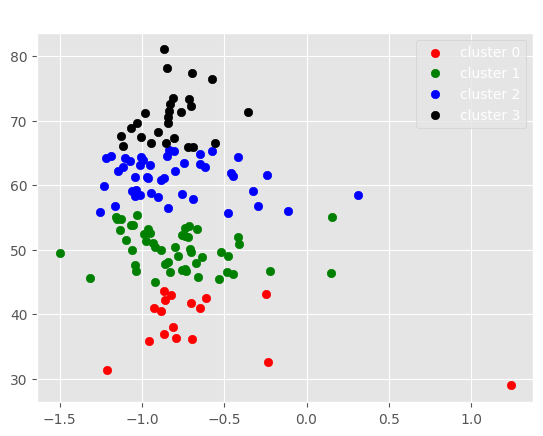

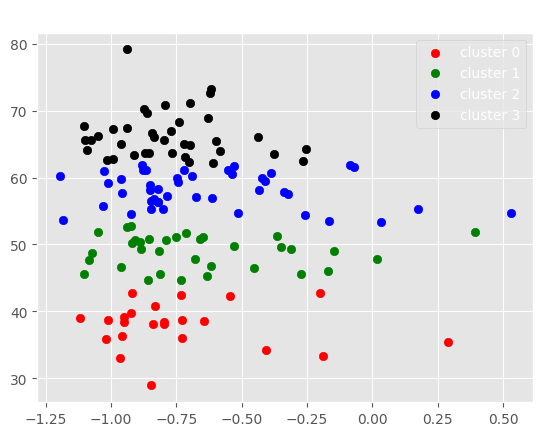

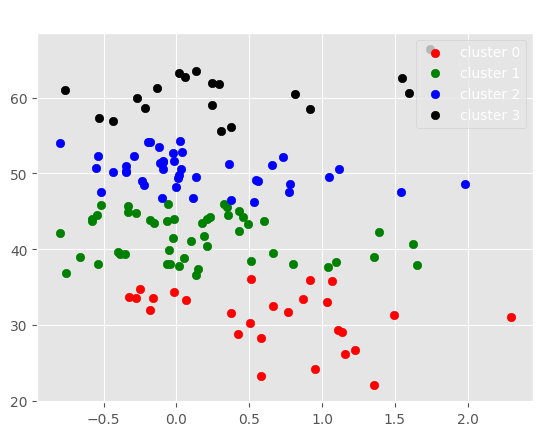

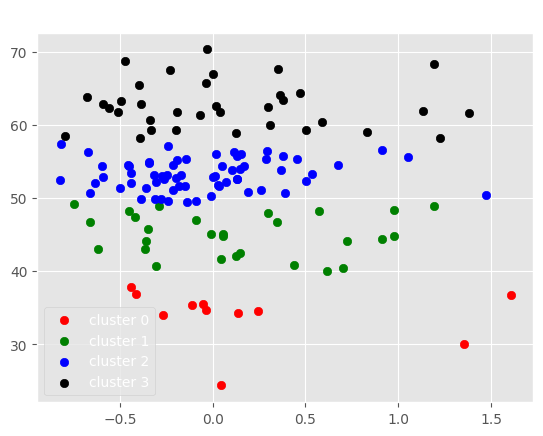

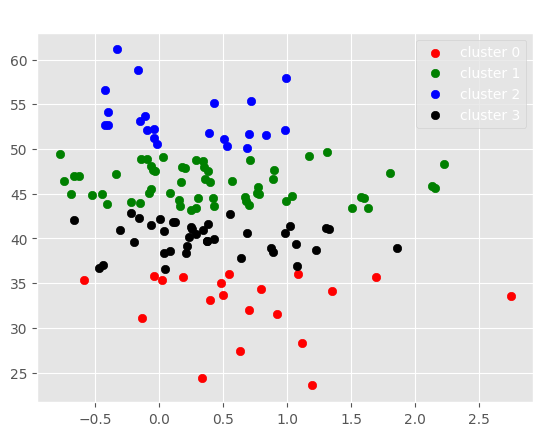

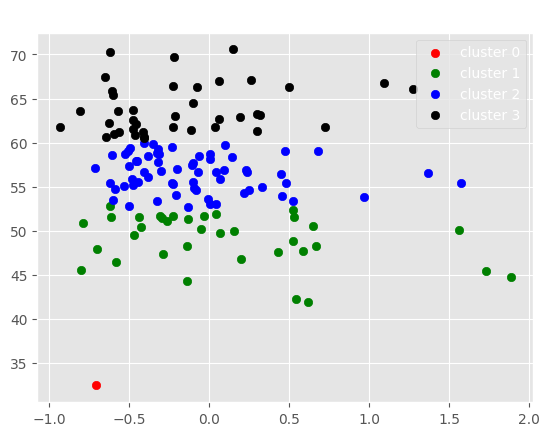

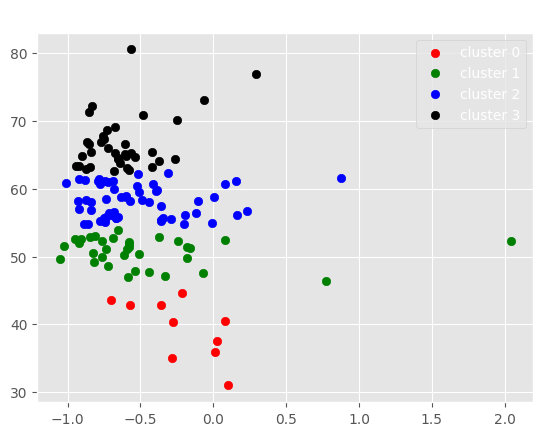

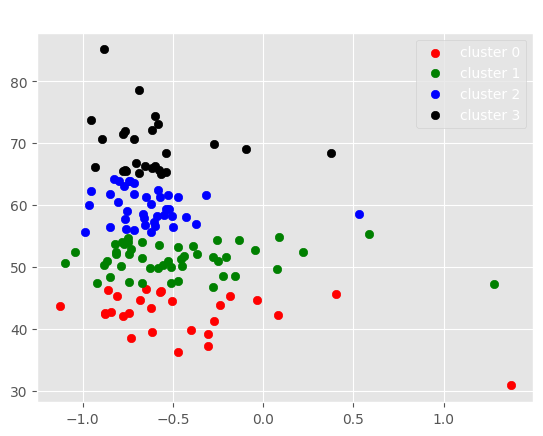

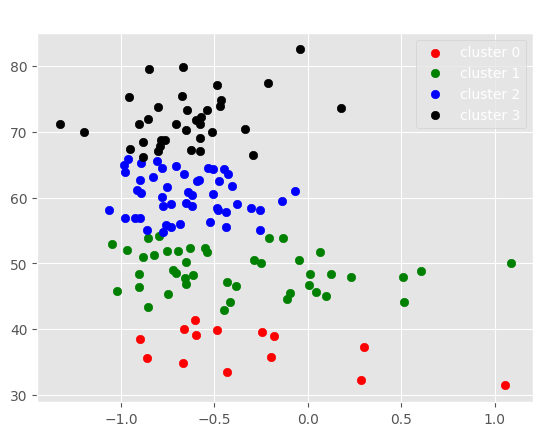

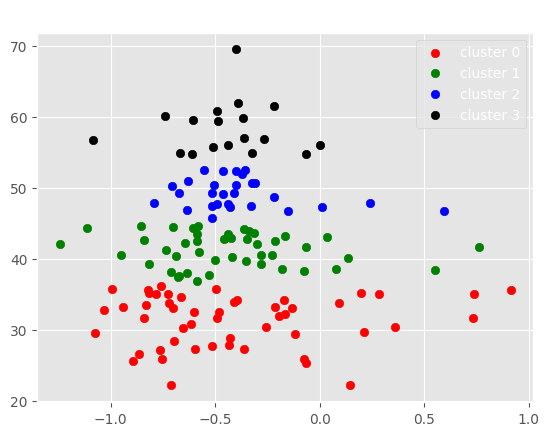

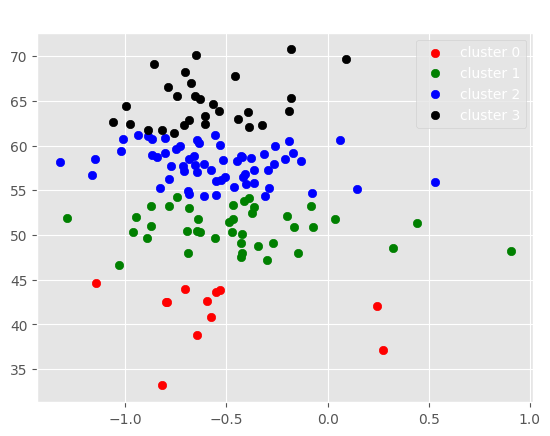

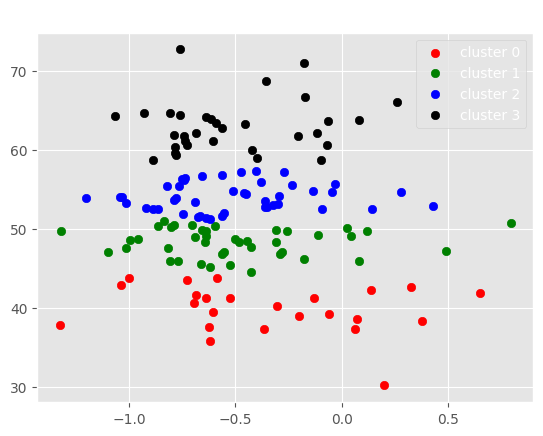

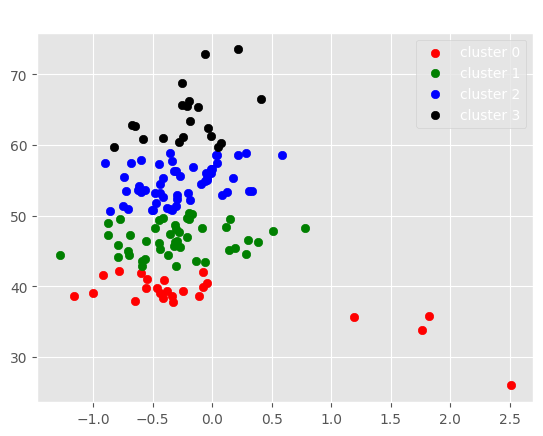

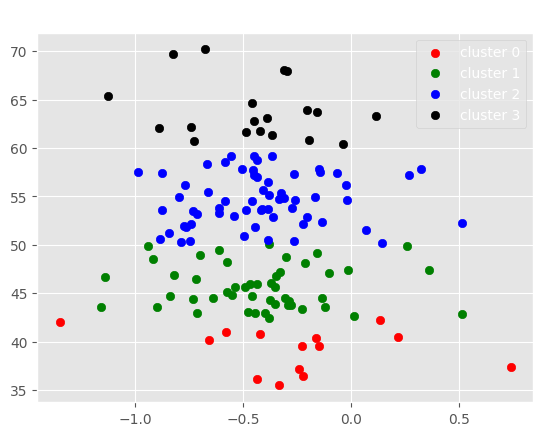

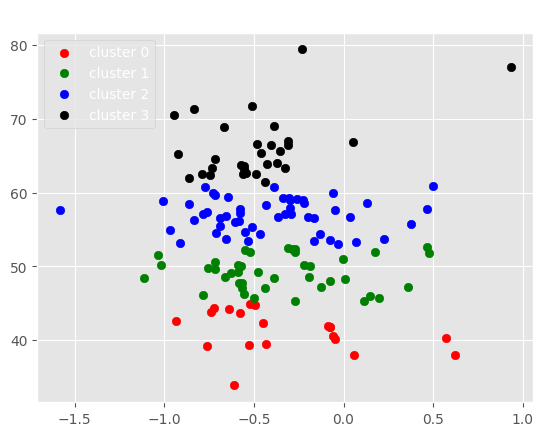

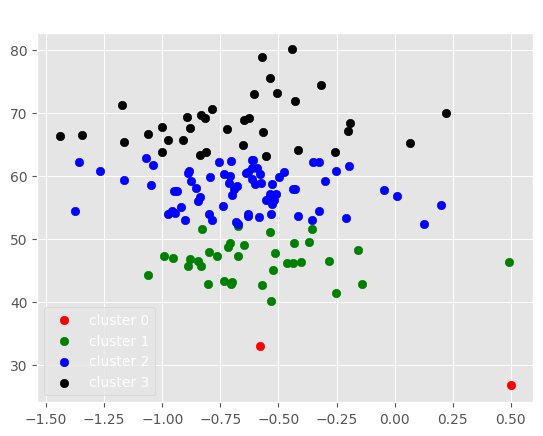

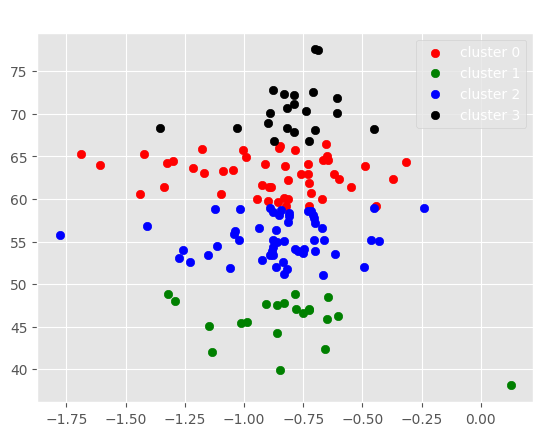

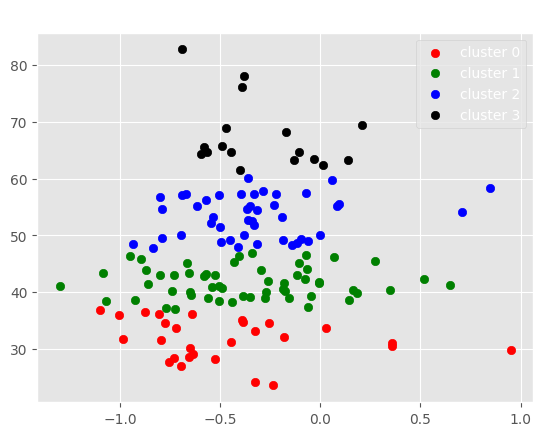

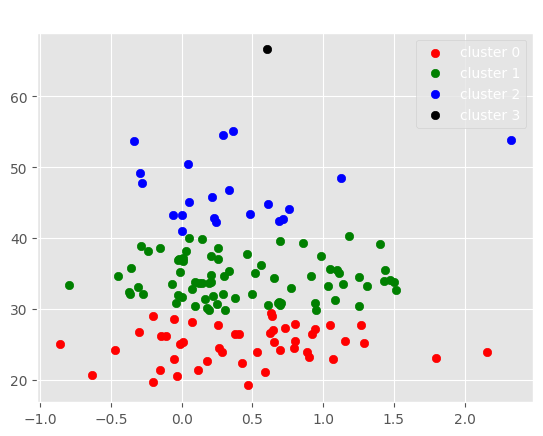

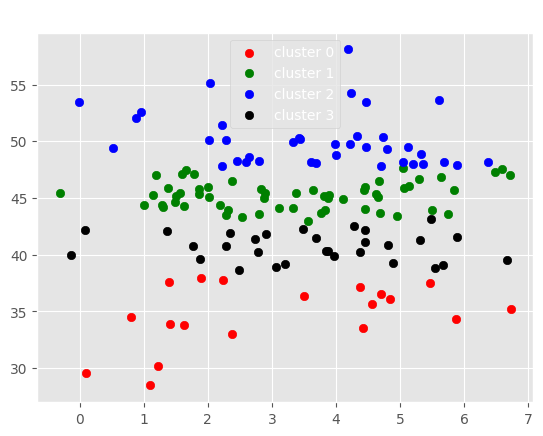

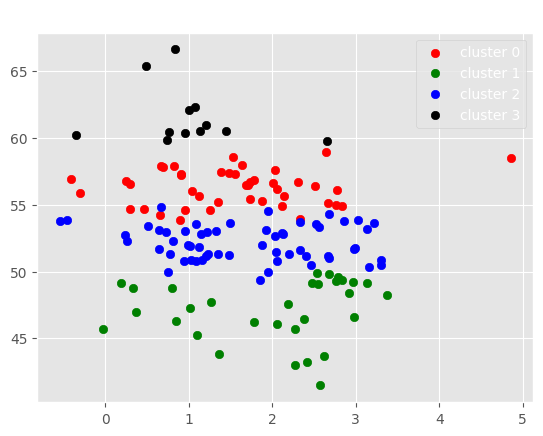

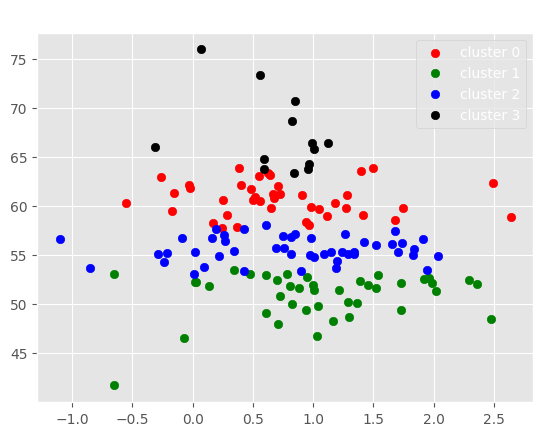

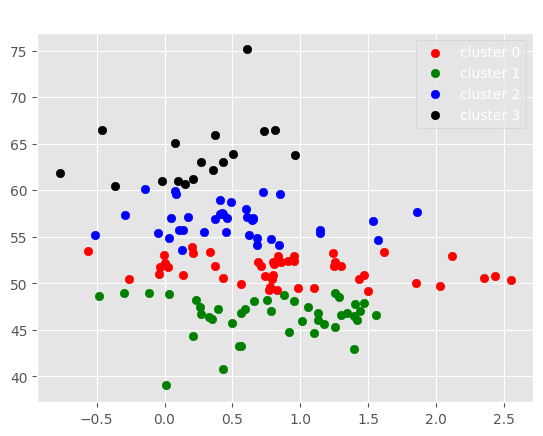

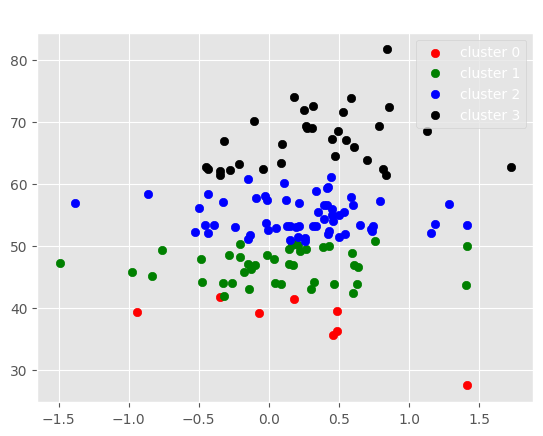

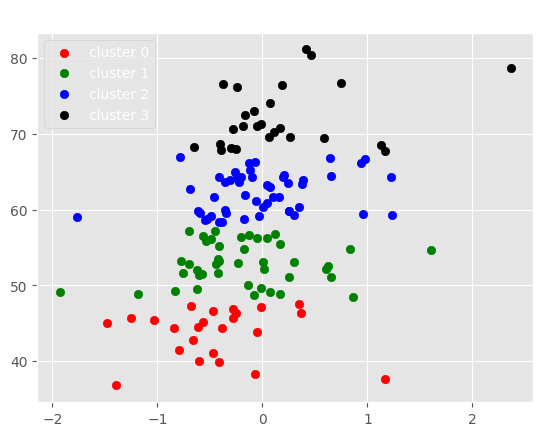

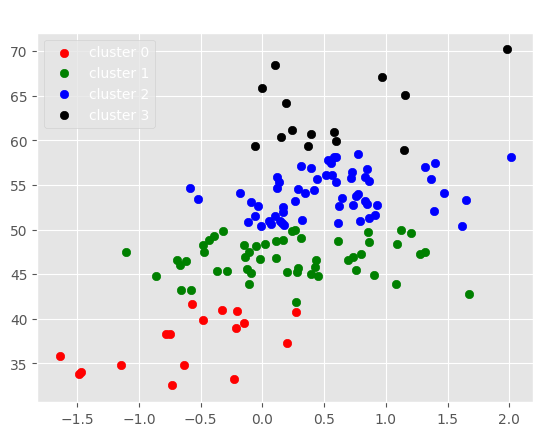

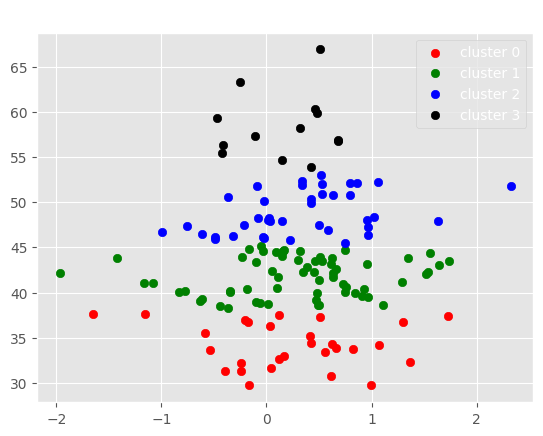

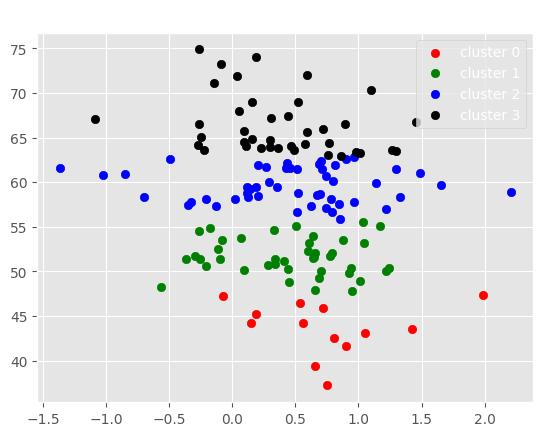

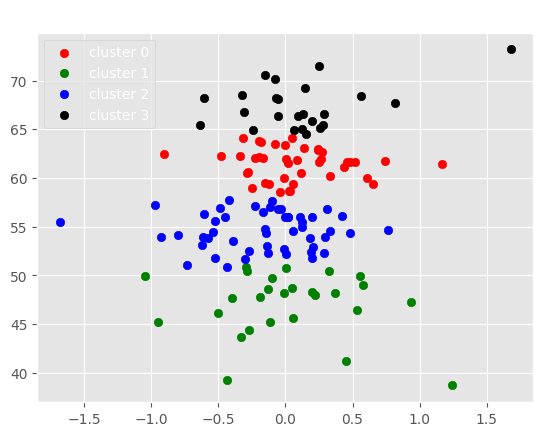

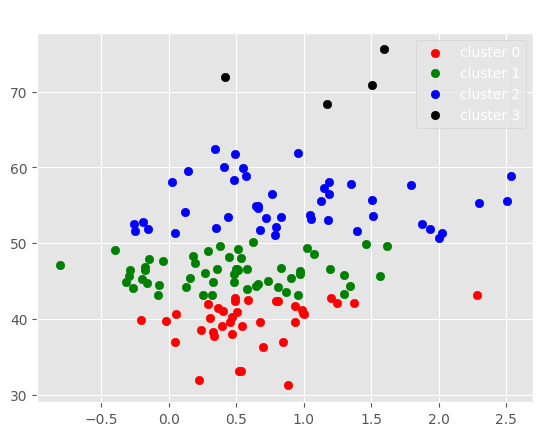

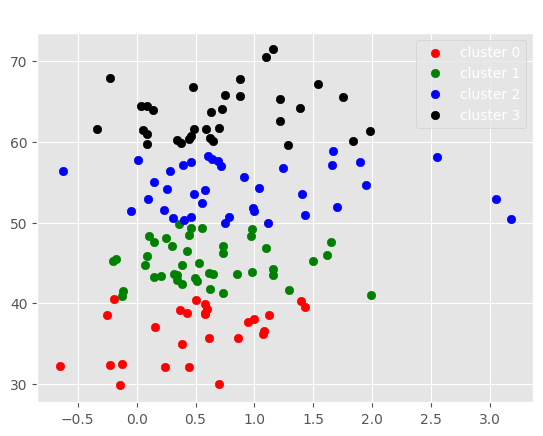

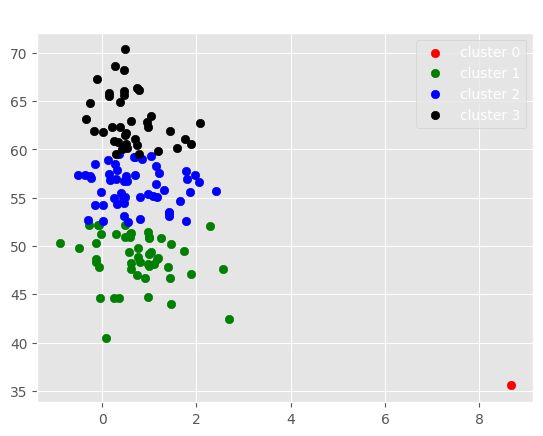

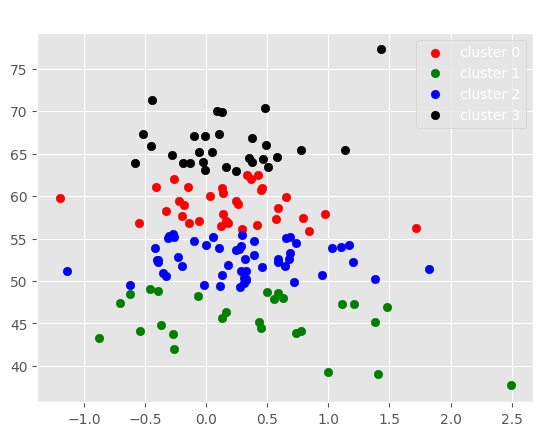

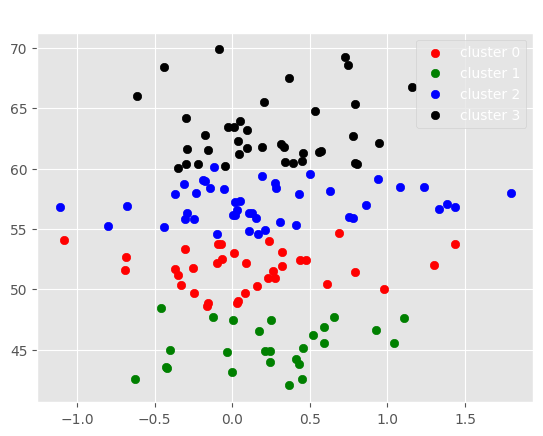

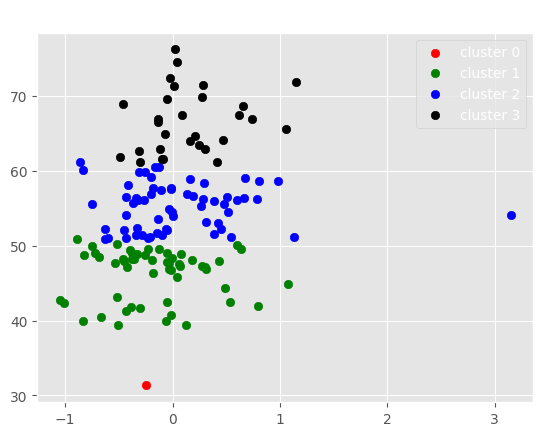

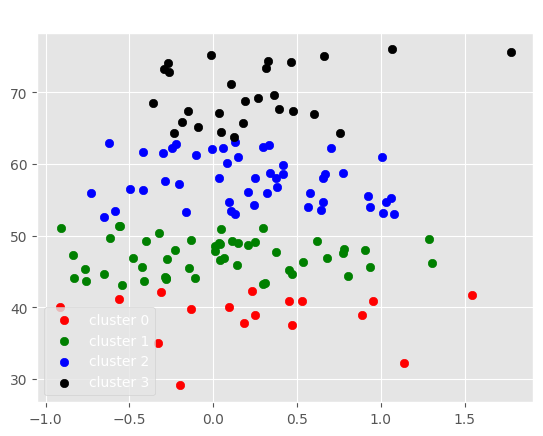

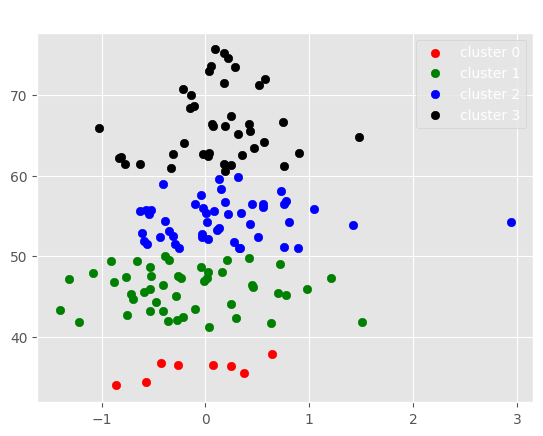

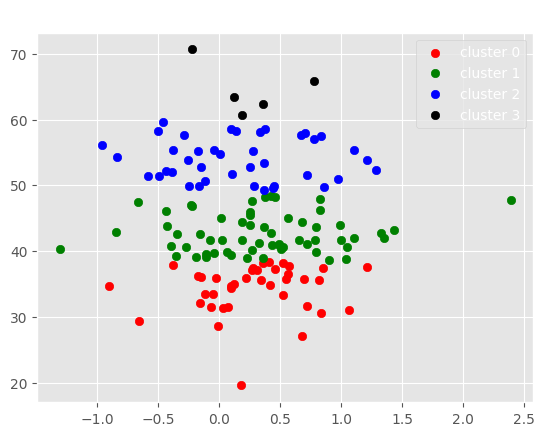

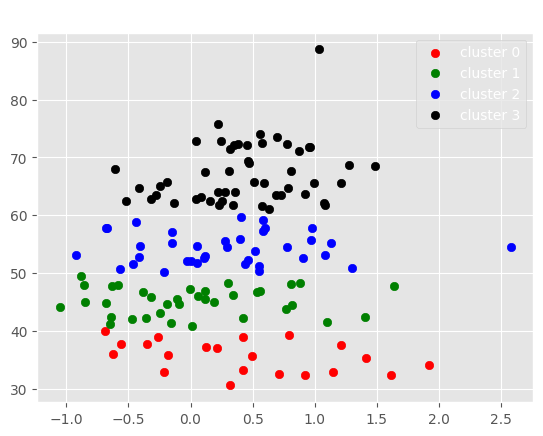

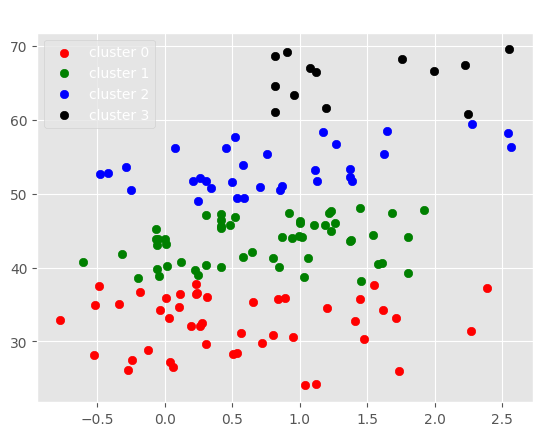

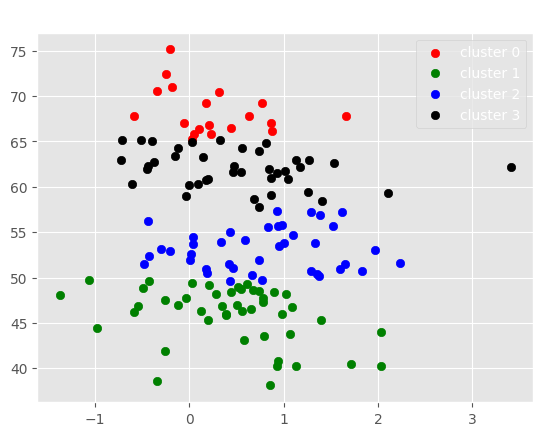

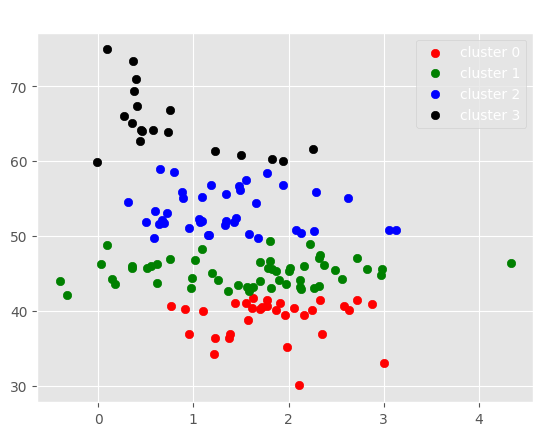

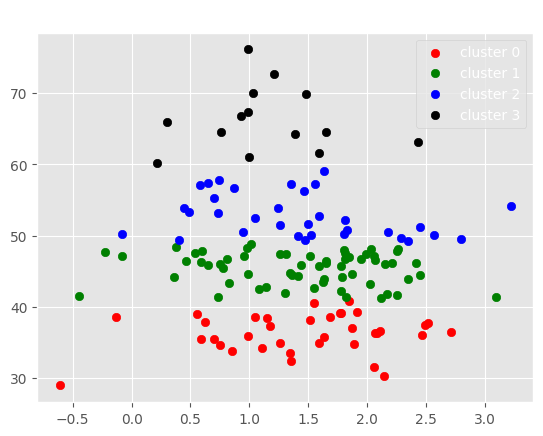

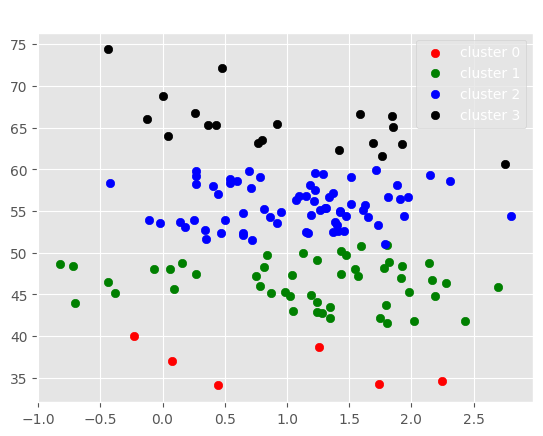

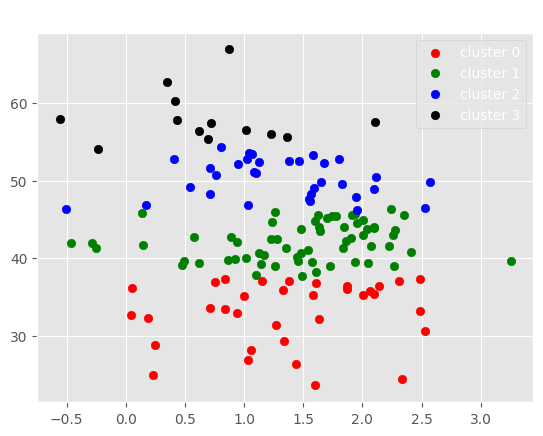

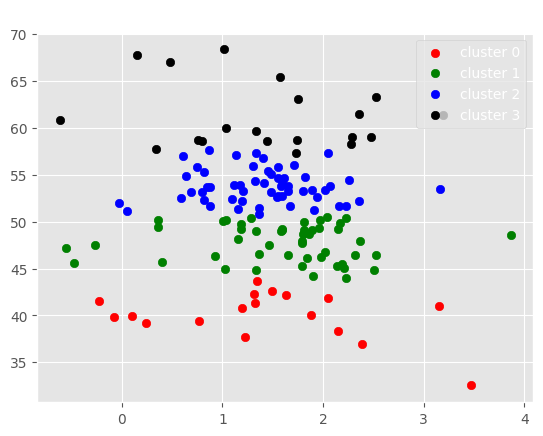

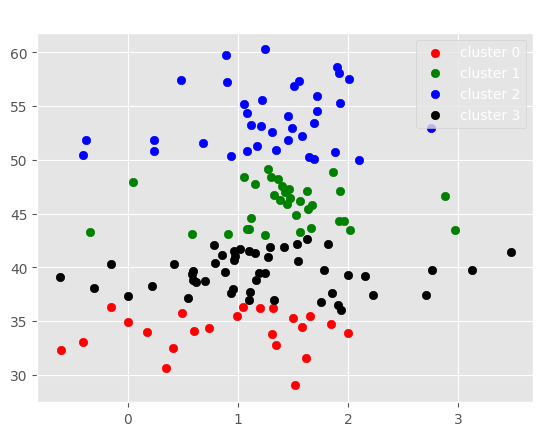

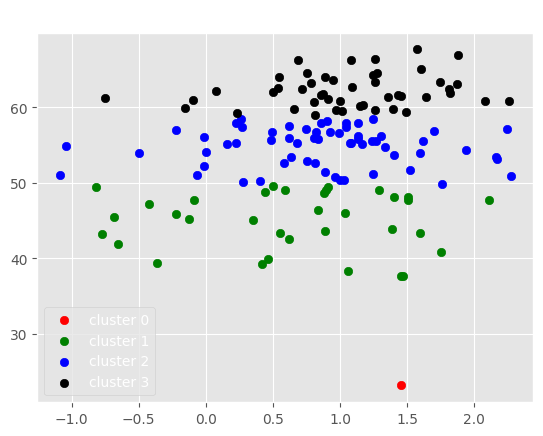

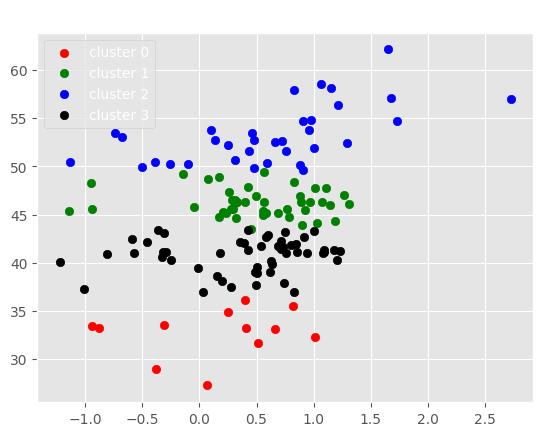

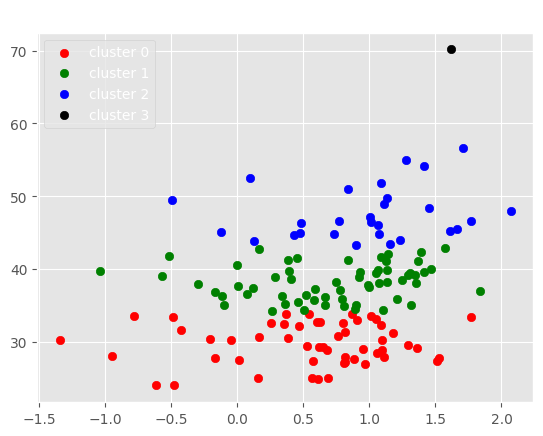

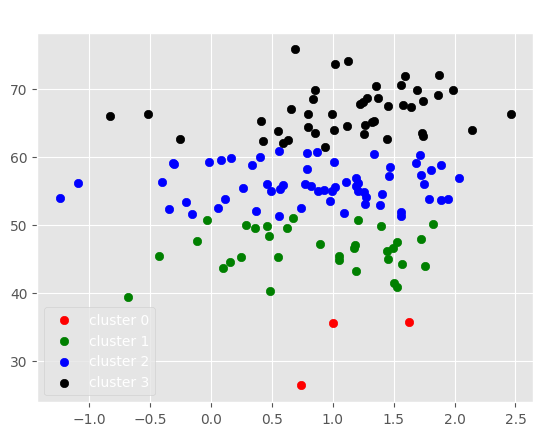

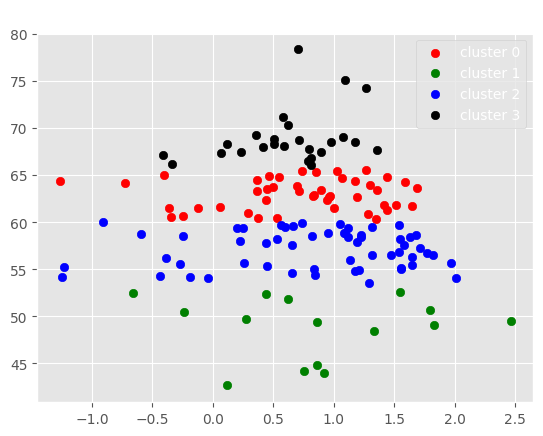

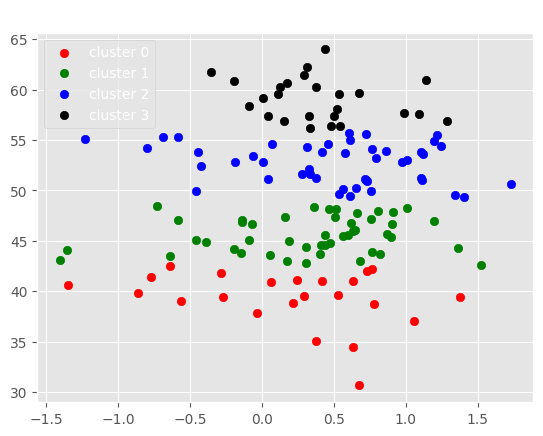

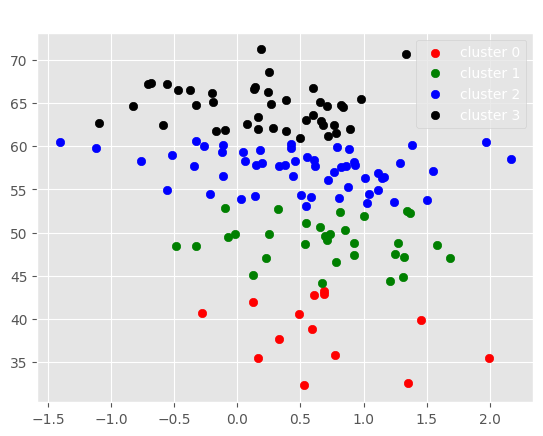

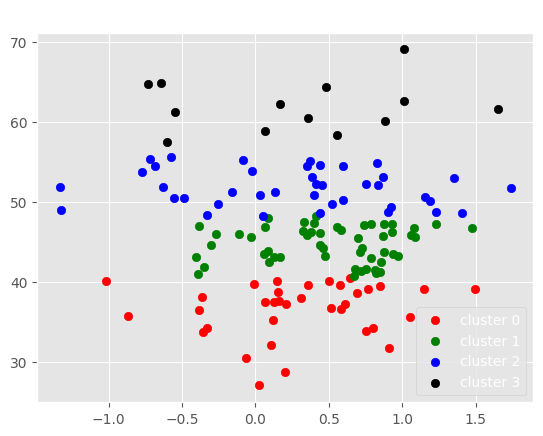

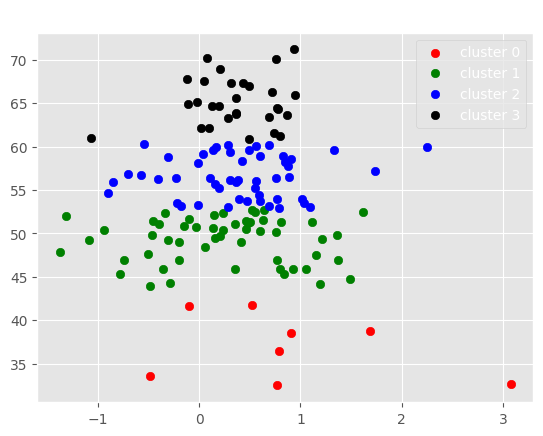

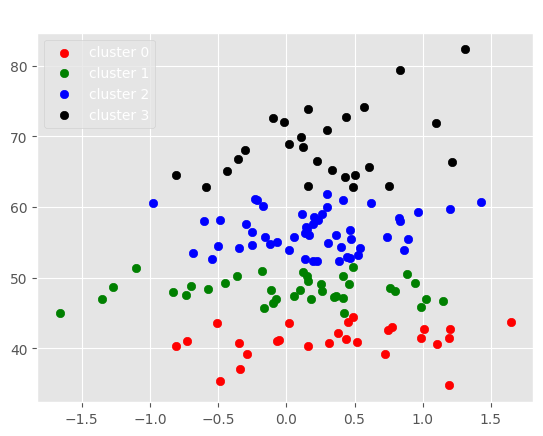

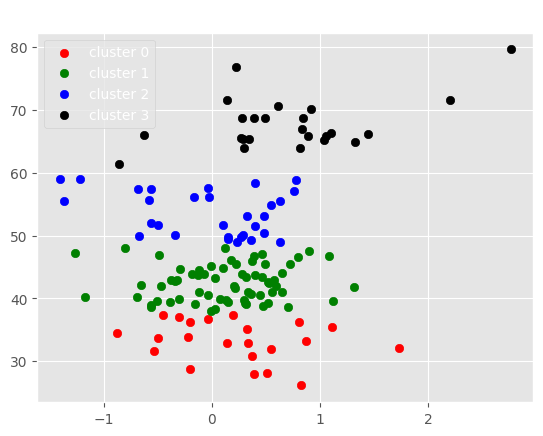

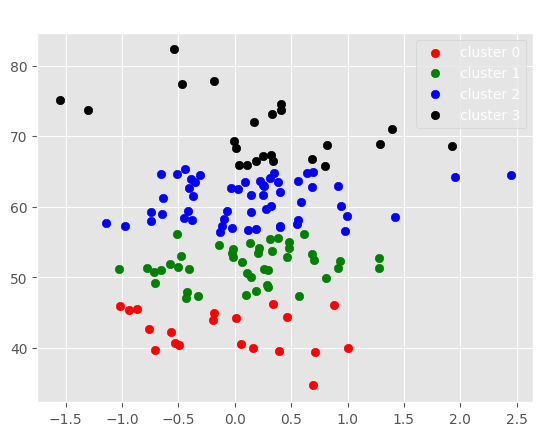

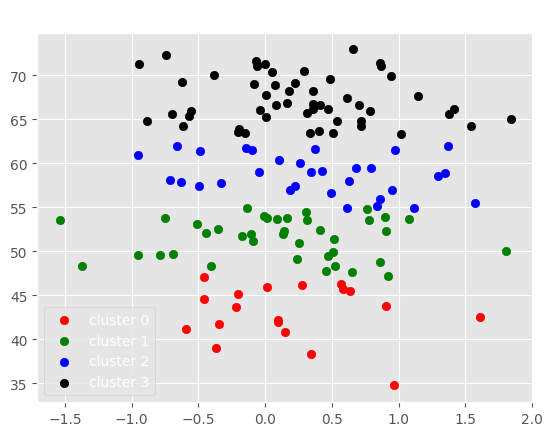

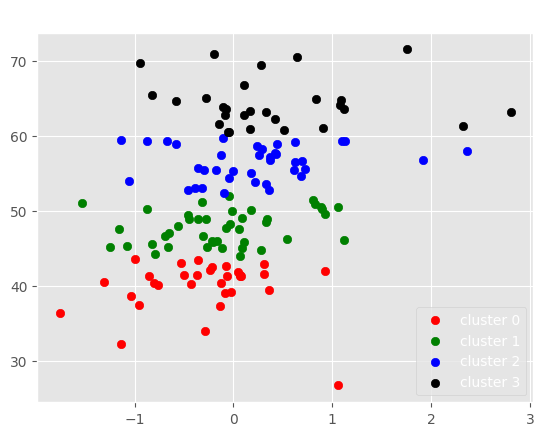

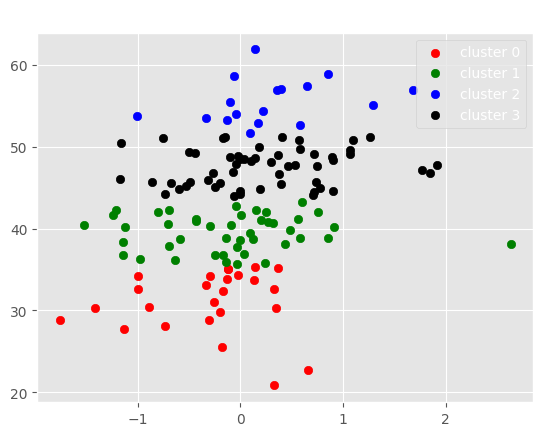

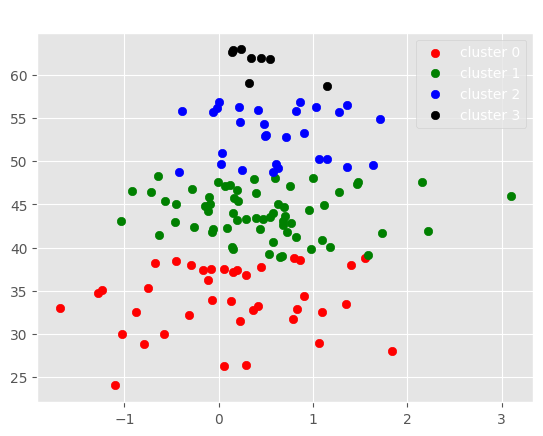

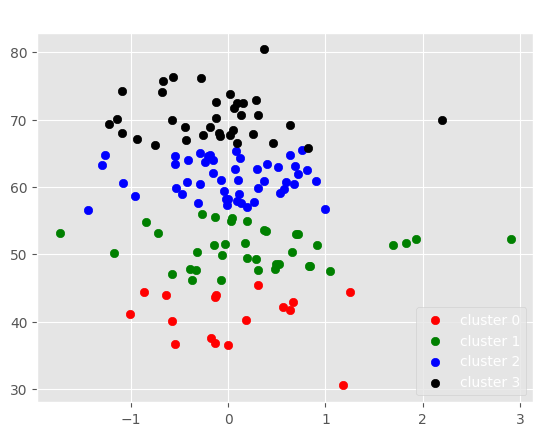

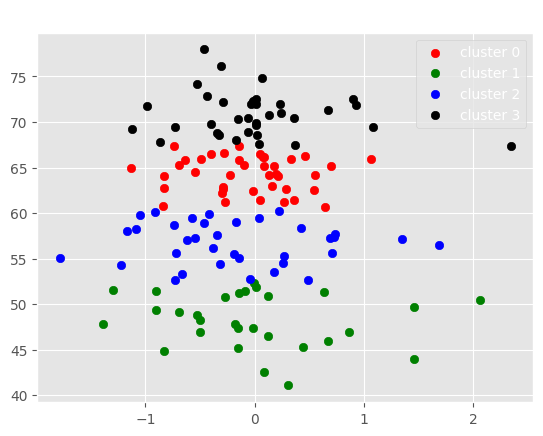

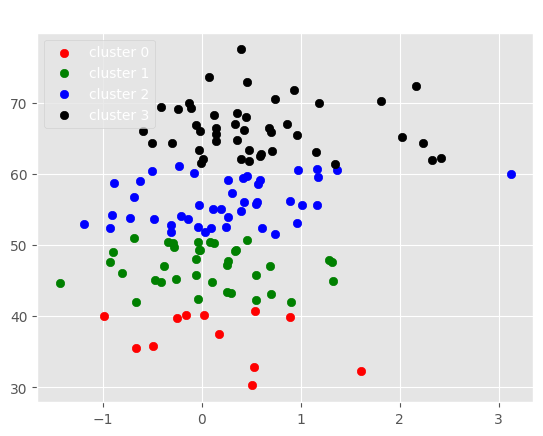

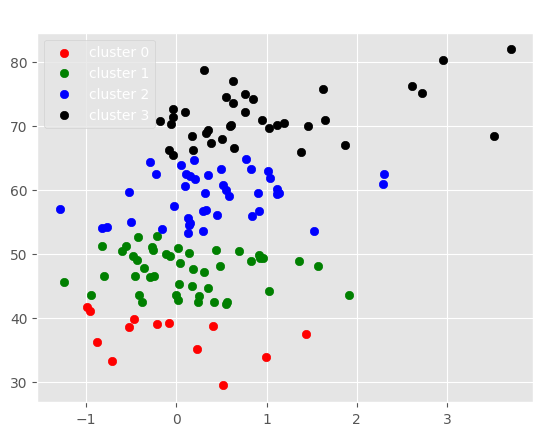

In [50]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

<!-- @format -->

### Apply pre-defined centroids.


In [21]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

<!-- @format -->

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

- First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

- Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [51]:
filtered_df = data[data['cluster'] == 3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d,
                                                         level=0).index.tolist()

fixed_dates

{'2018-03-01': ['AAPL',
  'ADBE',
  'AMZN',
  'BA',
  'BKNG',
  'CRM',
  'CSCO',
  'CTSH',
  'INTC',
  'MA',
  'MU',
  'NFLX',
  'NXPI',
  'PANW',
  'TJX'],
 '2018-04-01': ['AMT',
  'BKNG',
  'CL',
  'COP',
  'INTC',
  'NEE',
  'PANW',
  'STZ',
  'TJX',
  'WYNN'],
 '2018-05-01': ['CMG', 'COP', 'EOG', 'HAL', 'OXY', 'PXD', 'ULTA', 'VLO'],
 '2018-06-01': ['ADBE',
  'AMD',
  'AMZN',
  'BIIB',
  'CMG',
  'CSX',
  'EXPE',
  'GM',
  'LLY',
  'LOW',
  'META',
  'NEE',
  'NFLX',
  'OXY',
  'PANW',
  'TJX',
  'TXN',
  'VLO'],
 '2018-07-01': ['ACN',
  'AMT',
  'BSX',
  'COST',
  'CRM',
  'EA',
  'EOG',
  'KR',
  'MDLZ',
  'NEE',
  'NFLX',
  'NKE',
  'PARA',
  'PEP',
  'PG',
  'REGN',
  'SHW',
  'TJX',
  'VZ'],
 '2018-08-01': ['ABT',
  'AMD',
  'AMGN',
  'AMT',
  'BMY',
  'C',
  'CL',
  'CMCSA',
  'COST',
  'CSX',
  'DIS',
  'ELV',
  'EOG',
  'EXPE',
  'GILD',
  'HON',
  'JNJ',
  'JPM',
  'KO',
  'KR',
  'LLY',
  'LMT',
  'LUV',
  'MDLZ',
  'MDT',
  'MMM',
  'MRK',
  'ORLY',
  'PEP',
  'PFE',
  'P

<!-- @format -->

### Define portfolio optimization function

- We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

- To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

- Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).


In [52]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns


def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()

<!-- @format -->

- Download Fresh Daily Prices Data only for short listed stocks.


In [53]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[
                         0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  157 of 157 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-02-28  44.898846   31.969774   45.488472   39.848408  109.569885   
2017-03-01  45.605846   32.623211   46.216694   40.299213  110.974190   
2017-03-02  44.279018   32.429520   46.525642   40.387615  111.224632   
2017-03-03  45.344353   32.620888   46.591839   39.998676  110.589569   
2017-03-06  43.881943   32.518200   46.746319   39.892605  110.231796   
...               ...         ...         ...         ...         ...   
2024-02-06  14.900000  189.058762  173.289993  114.000000  364.700012   
2024-02-07  14.910000  189.168625  175.009995  113.309998  366.649994   
2024-02-08  14.950000  188.080017  174.789993  112.430000  368.480011   
2024-02-09  14.880000  188.850006  174.080002  111.809998  371.670013   
2024-02-12  14.930000  187.149994  173.070007  112.529999  367.429993   

Price                                                                  ...  \
Ticker            ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2017-02-28  118.339996   88.560333   86.300003  53.076389   33.457172  ...   
2017-03-01  120.349998   90.208641   88.930000  53.665947   34.039108  ...   
2017-03-02  119.900002   89.811699   87.320000  53.059784   33.706573  ...   
2017-03-03  120.040001   90.182777   85.320000  53.325500   34.057590  ...   
2017-03-06  120.150002   90.571106   82.940002  52.960136   34.048355  ...   
...                ...         ...         ...        ...         ...  ...   
2024-02-06  607.140015  250.809998  253.979996  68.769997  168.699997  ...   
2024-02-07  615.849976  250.270004  258.429993  69.809998  170.899994  ...   
2024-02-08  615.859985  251.080002  261.510010  68.410004  173.889999  ...   
2024-02-09  627.210022  249.990005  266.679993  69.120003  185.839996  ...   
2024-02-12  611.840027  250.070007  262.040009  69.730003  185.539993  ...   

Price         Volume                                                           \
Ticker             V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2017-02-28   8521900  9074700  2401900  17699200   3879900  5078100  15558900   
2017-03-01  11131400  4921900  2089400  16095600   3390500  4667800  25912700   
2017-03-02  10544200  7343000  1060900  10773400   3096800  4867100  17578600   
2017-03-03   5700600  4046600  1422600  11071600   3157600  3223100  14740000   
2017-03-06   7347600  3315300  1587700  10827300   2437500  3855000  13225500   
...              ...      ...      ...       ...       ...      ...       ...   
2024-02-06   4400000  7278200  4504000  17517600  10286300  5187200  13926600   
2024-02-07   4785900  3014900  1989800  21815600   9146300  4946900  15839600   
2024-02-08   5833400  2673500  1407400  19523500   8030900  7468400  10839200   
2024-02-09   4618000  3793900  1169200  18474900   8943500  6518000  16593000   
2024-02-12   3675600  2825000  1368200  15059700   8900400  4459100  14101400   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2017-02-28  15952600  2094100  16834200  
2017-03-01  13522700  6088500  17482100  
2017-03-02   8916300  2754100  14170300  
2017-03-03   9297900  1782100  12190400  
2017-03-06   9182600  1206000   9617200  
...              ...      ...       ...  
2024-02-06   4727100  2488000  13347900  
2024-02-07   5694200  3627500  13826800  
2024-02-08   4809300  6472400  19636900  
2024-02-09   4776100  2487900  20405000  
2024-02-12   4929400  1865300  18169100  

[1751 rows x 942 columns]

<!-- @format -->

- Calculate daily returns for each stock which could land up in our portfolio.

- Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

- If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

- Calculated each day portfolio return.


In [373]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date) +
                    pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(
            start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(
            start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:
                                 optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                       lower_bound=round(1/(len(optimization_df.columns)*2), 3))

            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(
                f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

        if success == False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                   index=optimization_df.columns.tolist(),
                                   columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
            .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                   left_index=True,
                   right_index=True)\
            .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(
            level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2017-11-01,0.001481
2017-11-02,0.002892
2017-11-03,0.006382
2017-11-06,0.002932
2017-11-07,0.002917
...,...
2023-09-25,0.003587
2023-09-26,-0.011112
2023-09-27,0.004989


<!-- @format -->

## 8. Visualize Portfolio returns and compare to SP500 returns.


In [374]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename(
    {'Adj Close': 'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2017-11-01,0.001481,0.001321
2017-11-02,0.002892,0.000388
2017-11-03,0.006382,0.003333
2017-11-06,0.002932,0.001547
2017-11-07,0.002917,-0.000696
...,...,...
2023-09-25,0.003587,0.004196
2023-09-26,-0.011112,-0.014800
2023-09-27,0.004989,0.000399
2023-09-28,0.007681,0.005781


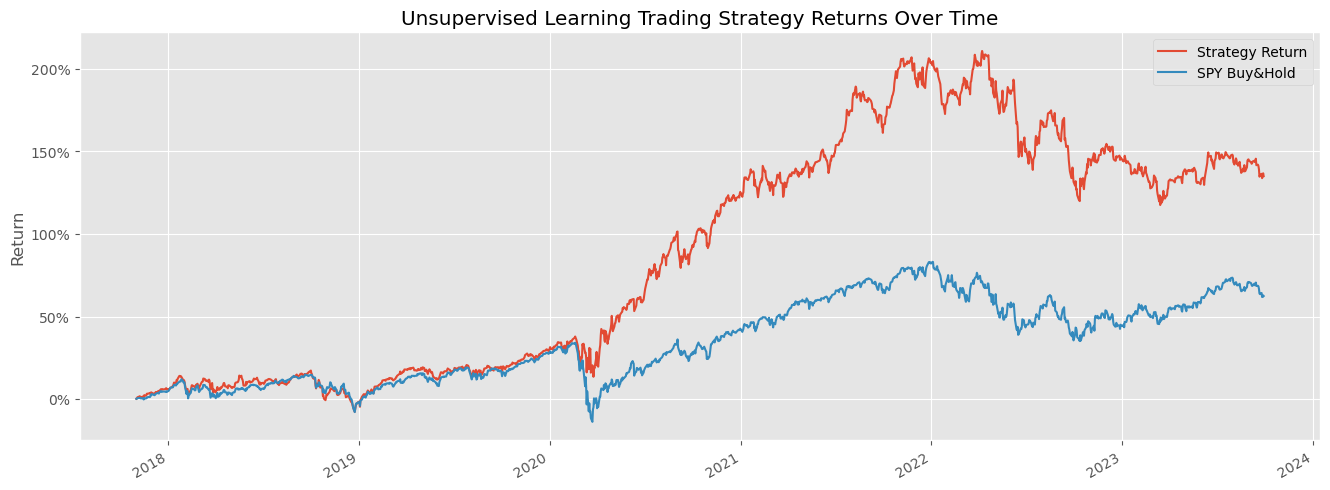

In [375]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16, 6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

<!-- @format -->

# Twitter Sentiment Investing Strategy

## 1. Load Twitter Sentiment Data

- Load the twitter sentiment dataset, set the index, calculat engagement ratio and filter out stocks with no significant twitter activity.


In [383]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os
plt.style.use('ggplot')

data_folder = 'C:/Users/user/Desktop/Python Scripts'

sentiment_df = pd.read_csv(os.path.join(data_folder, 'sentiment_data.csv'))

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

sentiment_df = sentiment_df.set_index(['date', 'symbol'])

sentiment_df['engagement_ratio'] = sentiment_df['twitterComments'] / \
    sentiment_df['twitterLikes']

sentiment_df = sentiment_df[(sentiment_df['twitterLikes'] > 20) & (
    sentiment_df['twitterComments'] > 10)]

sentiment_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

<!-- @format -->

## 2. Aggregate Monthly and calculate average sentiment for the month

- Aggregate on a monthly level and calculate average monthly metric, for the one we choose.


In [424]:
aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
                 [['engagement_ratio']].mean())

aggragated_df['rank'] = (aggragated_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))

aggragated_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

<!-- @format -->

## 3. Select Top 5 Stocks based on their cross-sectional ranking for each month

- Select top 5 stocks by rank for each month and fix the date to start at beginning of next month.


In [425]:
filtered_df = aggragated_df[aggragated_df['rank'] < 6].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

filtered_df.head(20)

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
2022-01-01 D               0.801994   5.0
           FCX             0.841220   4.0
           L               6.507246   1.0
           LUV             1.303215   2.0
           MA              0.883401   3.0
2022-02-01 AMD             0.715556   4.0
           D               1.136678   1.0
           FCX             0.655237   5.0
           LUV             1.035258   2.0
           MA              0.729063   3.0
2022-03-01 FCX             1.138332   2.0
           GILD            0.530886   5.0
           LUV             1.574377   1.0
           MRO             0.581748   4.0
           OXY             1.025579   3.0

<!-- @format -->

## 4. Extract the stocks to form portfolios with at the start of each new month

- Create a dictionary containing start of month and corresponded selected stocks.


In [426]:
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d,
                                                         level=0).index.tolist()

fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

<!-- @format -->

## 5. Download fresh stock prices for only selected/shortlisted stocks


In [427]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()

prices_df = yf.download(tickers=stocks_list,
                        start='2021-01-01',
                        end='2023-03-01')

[*********************100%%**********************]  85 of 85 completed


<!-- @format -->

## 6. Calculate Portfolio Returns with monthly rebalancing


In [428]:
returns_df = np.log(prices_df['Adj Close']).diff().dropna()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    end_date = (pd.to_datetime(start_date) +
                pd.offsets.MonthEnd()).strftime('%Y-%m-%d')

    cols = fixed_dates[start_date]

    temp_df = returns_df[start_date:end_date][cols].mean(
        axis=1).to_frame('portfolio_return')

    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

portfolio_df

,portfolio_return
Date,
2021-12-01,-0.016417
2021-12-02,0.024872
2021-12-03,-0.007711
2021-12-06,0.023926
2021-12-07,0.030547
...,...
2023-02-22,-0.007870
2023-02-23,-0.007323
2023-02-24,-0.009463


<!-- @format -->

## 7. Download NASDAQ/QQQ prices and calculate returns to compare to our strategy


In [429]:
qqq_df = yf.download(tickers='QQQ',
                     start='2021-01-01',
                     end='2023-03-01')

qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')

portfolio_df = portfolio_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,portfolio_return,nasdaq_return
Date,,
2021-12-01,-0.016417,-0.017159
2021-12-02,0.024872,0.007181
2021-12-03,-0.007711,-0.017542
2021-12-06,0.023926,0.007981
2021-12-07,0.030547,0.029669
...,...,...
2023-02-22,-0.007870,0.000748
2023-02-23,-0.007323,0.008696
2023-02-24,-0.009463,-0.016886


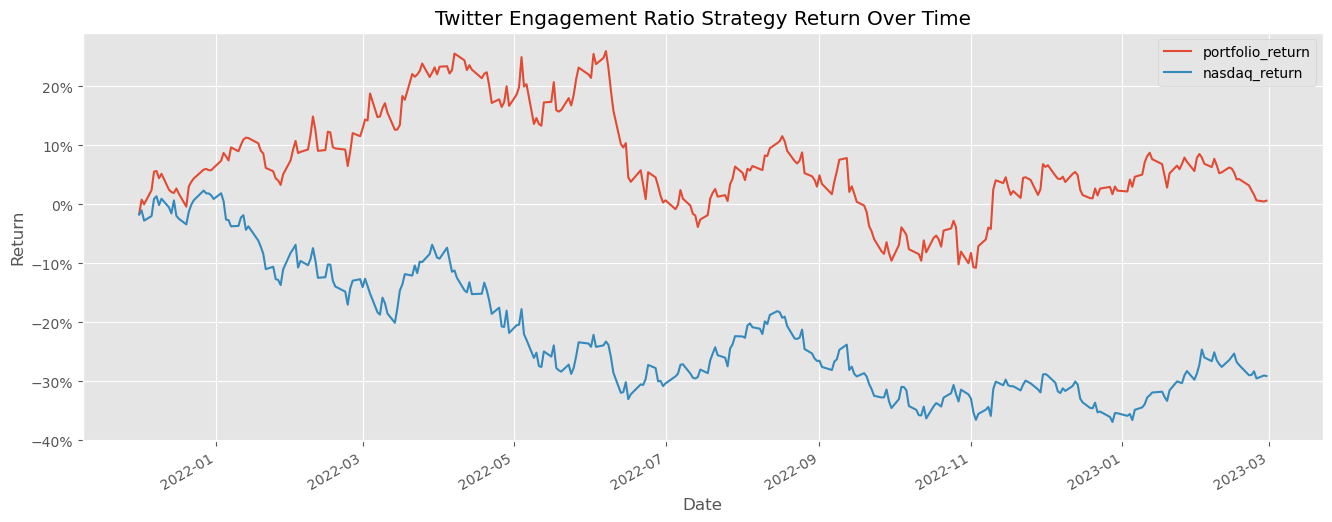

In [430]:
portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16, 6))

plt.title('Twitter Engagement Ratio Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

<!-- @format -->

# Intraday Strategy Using GARCH Model

- Using simulated daily data and intraday 5-min data.
- Load Daily and 5-minute data.
- Define function to fit GARCH model on the daily data and predict 1-day ahead volatility in a rolling window.
- Calculate prediction premium and form a daily signal from it.
- Merge with intraday data and calculate intraday indicators to form the intraday signal.
- Generate the position entry and hold until the end of the day.
- Calculate final strategy returns.


<!-- @format -->

## 1. Load Simulated Daily and Simulated 5-minute data.

- We are loading both datasets, set the indexes and calculate daily log returns.


In [36]:
import matplotlib.pyplot as plt
from arch import arch_model
import pandas_ta
import pandas as pd
import numpy as np
import os

data_folder = 'C:/Users/user/Desktop/Python Scripts'

daily_df = pd.read_csv(os.path.join(data_folder, 'simulated_daily_data.csv'))

daily_df = daily_df.drop('Unnamed: 7', axis=1)

daily_df['Date'] = pd.to_datetime(daily_df['Date'])

daily_df = daily_df.set_index('Date')


intraday_5min_df = pd.read_csv(os.path.join(
    data_folder, 'simulated_5min_data.csv'))

intraday_5min_df = intraday_5min_df.drop('Unnamed: 6', axis=1)

intraday_5min_df['datetime'] = pd.to_datetime(intraday_5min_df['datetime'])

intraday_5min_df = intraday_5min_df.set_index('datetime')

intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df.index.date)

intraday_5min_df

<!-- @format -->

## 2. Define function to fit GARCH model and predict 1-day ahead volatility in a rolling window.

- We are first calculating the 6-month rolling variance and then we are creating a function in a 6-month rolling window to fit a garch model and predict the next day variance.


In [23]:
daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()

daily_df['variance'] = daily_df['log_ret'].rolling(180).var()

daily_df = daily_df['2020':]


def predict_volatility(x):

    best_model = arch_model(y=x,
                            p=1,
                            q=3).fit(update_freq=5,
                                     disp='off')

    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1, 0]

    print(x.index[-1])

    return variance_forecast


daily_df['predictions'] = daily_df['log_ret'].rolling(
    180).apply(lambda x: predict_volatility(x))

daily_df = daily_df.dropna()

daily_df

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002459. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002459. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2020-06-28 00:00:00
2020-06-29 00:00:00
2020-06-30 00:00:00
2020-07-01 00:00:00
2020-07-02 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002442. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002442. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2020-07-03 00:00:00
2020-07-04 00:00:00
2020-07-05 00:00:00
2020-07-06 00:00:00
2020-07-07 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002422. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00242. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2020-07-08 00:00:00
2020-07-09 00:00:00
2020-07-10 00:00:00
2020-07-11 00:00:00
2020-07-12 00:00:00
2020-07-13 00:00:00
2020-07-14 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002377. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002377. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2020-07-15 00:00:00
2020-07-16 00:00:00
2020-07-17 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311

2020-07-18 00:00:00
2020-07-19 00:00:00
2020-07-20 00:00:00
2020-07-21 00:00:00
2020-07-22 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002369. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002366. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2020-07-23 00:00:00
2020-07-24 00:00:00
2020-07-25 00:00:00
2020-07-26 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002357. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2020-07-27 00:00:00
2020-07-28 00:00:00
2020-07-29 00:00:00
2020-07-30 00:00:00
2020-07-31 00:00:00
2020-08-01 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002404. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002404. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2020-08-02 00:00:00
2020-08-03 00:00:00
2020-08-04 00:00:00
2020-08-05 00:00:00
2020-08-06 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002424. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002424. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2020-08-07 00:00:00
2020-08-08 00:00:00
2020-08-09 00:00:00
2020-08-10 00:00:00
2020-08-11 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00243. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002424. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2020-08-12 00:00:00
2020-08-13 00:00:00
2020-08-14 00:00:00
2020-08-15 00:00:00
2020-08-16 00:00:00
2020-08-17 00:00:00
2020-08-18 00:00:00
2020-08-19 00:00:00
2020-08-20 00:00:00
2020-08-21 00:00:00
2020-08-22 00:00:00
2020-08-23 00:00:00
2020-08-24 00:00:00
2020-08-25 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002425. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002425. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2020-08-26 00:00:00
2020-08-27 00:00:00
2020-08-28 00:00:00
2020-08-29 00:00:00
2020-08-30 00:00:00
2020-08-31 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002385. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2020-09-01 00:00:00
2020-09-02 00:00:00
2020-09-03 00:00:00
2020-09-04 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002389. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002452. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2020-09-05 00:00:00
2020-09-06 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002408. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002408. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


2020-09-07 00:00:00
2020-09-08 00:00:00
2020-09-09 00:00:00
2020-09-10 00:00:00
2020-09-11 00:00:00
2020-09-12 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001198. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001132. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2020-09-13 00:00:00
2020-09-14 00:00:00
2020-09-15 00:00:00
2020-09-16 00:00:00
2020-09-17 00:00:00
2020-09-18 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001065. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009166. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pytho

2020-09-19 00:00:00
2020-09-20 00:00:00
2020-09-21 00:00:00
2020-09-22 00:00:00
2020-09-23 00:00:00
2020-09-24 00:00:00
2020-09-25 00:00:00
2020-09-26 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008391. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008508. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2020-09-27 00:00:00
2020-09-28 00:00:00
2020-09-29 00:00:00
2020-09-30 00:00:00
2020-10-01 00:00:00
2020-10-02 00:00:00
2020-10-03 00:00:00
2020-10-04 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007966. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007936. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2020-10-05 00:00:00
2020-10-06 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007679. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007453. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


2020-10-07 00:00:00
2020-10-08 00:00:00
2020-10-09 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007476. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007472. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2020-10-10 00:00:00
2020-10-11 00:00:00
2020-10-12 00:00:00
2020-10-13 00:00:00
2020-10-14 00:00:00
2020-10-15 00:00:00
2020-10-16 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007466. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007415. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2020-10-17 00:00:00
2020-10-18 00:00:00
2020-10-19 00:00:00
2020-10-20 00:00:00
2020-10-21 00:00:00
2020-10-22 00:00:00
2020-10-23 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007053. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007021. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2020-10-24 00:00:00
2020-10-25 00:00:00
2020-10-26 00:00:00
2020-10-27 00:00:00
2020-10-28 00:00:00
2020-10-29 00:00:00
2020-10-30 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007206. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006442. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2020-10-31 00:00:00
2020-11-01 00:00:00
2020-11-02 00:00:00
2020-11-03 00:00:00
2020-11-04 00:00:00
2020-11-05 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006545. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006519. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2020-11-06 00:00:00
2020-11-07 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000638. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006444. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


2020-11-08 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006322. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


2020-11-09 00:00:00
2020-11-10 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006205. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006123. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


2020-11-11 00:00:00
2020-11-12 00:00:00
2020-11-13 00:00:00
2020-11-14 00:00:00
2020-11-15 00:00:00
2020-11-16 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000614. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyth

2020-11-17 00:00:00
2020-11-18 00:00:00
2020-11-19 00:00:00
2020-11-20 00:00:00
2020-11-21 00:00:00
2020-11-22 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006233. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006234. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2020-11-23 00:00:00
2020-11-24 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006135. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006157. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


2020-11-25 00:00:00
2020-11-26 00:00:00
2020-11-27 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006593. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000655. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyth

2020-11-28 00:00:00
2020-11-29 00:00:00
2020-11-30 00:00:00
2020-12-01 00:00:00
2020-12-02 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006114. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006404. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2020-12-03 00:00:00
2020-12-04 00:00:00
2020-12-05 00:00:00
2020-12-06 00:00:00
2020-12-07 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006619. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006642. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2020-12-08 00:00:00
2020-12-09 00:00:00
2020-12-10 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006579. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006599. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2020-12-11 00:00:00
2020-12-12 00:00:00
2020-12-13 00:00:00
2020-12-14 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006676. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006686. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2020-12-15 00:00:00
2020-12-16 00:00:00
2020-12-17 00:00:00
2020-12-18 00:00:00
2020-12-19 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007095. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007315. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2020-12-20 00:00:00
2020-12-21 00:00:00
2020-12-22 00:00:00
2020-12-23 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007306. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007376. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2020-12-24 00:00:00
2020-12-25 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000746. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007685. Parameter


2020-12-26 00:00:00
2020-12-27 00:00:00
2020-12-28 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007686. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007718. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2020-12-29 00:00:00
2020-12-30 00:00:00
2020-12-31 00:00:00
2021-01-01 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007816. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007816. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2021-01-02 00:00:00
2021-01-03 00:00:00
2021-01-04 00:00:00
2021-01-05 00:00:00
2021-01-06 00:00:00
2021-01-07 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000814. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008189. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyth

2021-01-08 00:00:00
2021-01-09 00:00:00
2021-01-10 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008857. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000903. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyth

2021-01-11 00:00:00
2021-01-12 00:00:00
2021-01-13 00:00:00
2021-01-14 00:00:00
2021-01-15 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009561. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009987. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2021-01-16 00:00:00
2021-01-17 00:00:00
2021-01-18 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001039. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001039. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-01-19 00:00:00
2021-01-20 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001044. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001168. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


2021-01-21 00:00:00
2021-01-22 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001188. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001141. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


2021-01-23 00:00:00
2021-01-24 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00114. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00114. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


2021-01-25 00:00:00
2021-01-26 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00114. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


2021-01-27 00:00:00
2021-01-28 00:00:00
2021-01-29 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001207. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001184. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-01-30 00:00:00
2021-01-31 00:00:00
2021-02-01 00:00:00
2021-02-02 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001192. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-02-03 00:00:00
2021-02-04 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001209. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001212. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


2021-02-05 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001214. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


2021-02-06 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001204. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


2021-02-07 00:00:00
2021-02-08 00:00:00
2021-02-09 00:00:00
2021-02-10 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001353. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-02-11 00:00:00
2021-02-12 00:00:00
2021-02-13 00:00:00
2021-02-14 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001382. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00138. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2021-02-15 00:00:00
2021-02-16 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00138. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001388. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


2021-02-17 00:00:00
2021-02-18 00:00:00
2021-02-19 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00139. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2021-02-20 00:00:00
2021-02-21 00:00:00
2021-02-22 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001407. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001433. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-02-23 00:00:00
2021-02-24 00:00:00
2021-02-25 00:00:00
2021-02-26 00:00:00
2021-02-27 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001501. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001522. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-02-28 00:00:00
2021-03-01 00:00:00
2021-03-02 00:00:00
2021-03-03 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001553. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001484. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-03-04 00:00:00
2021-03-05 00:00:00
2021-03-06 00:00:00
2021-03-07 00:00:00
2021-03-08 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001493. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001493. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-03-09 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001505. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


2021-03-10 00:00:00
2021-03-11 00:00:00
2021-03-12 00:00:00
2021-03-13 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001507. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001507. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-03-14 00:00:00
2021-03-15 00:00:00
2021-03-16 00:00:00
2021-03-17 00:00:00
2021-03-18 00:00:00
2021-03-19 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001556. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001556. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-03-20 00:00:00
2021-03-21 00:00:00
2021-03-22 00:00:00
2021-03-23 00:00:00
2021-03-24 00:00:00
2021-03-25 00:00:00
2021-03-26 00:00:00
2021-03-27 00:00:00
2021-03-28 00:00:00
2021-03-29 00:00:00
2021-03-30 00:00:00
2021-03-31 00:00:00
2021-04-01 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001586. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001583. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-04-02 00:00:00
2021-04-03 00:00:00
2021-04-04 00:00:00
2021-04-05 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001591. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001587. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-04-06 00:00:00
2021-04-07 00:00:00
2021-04-08 00:00:00
2021-04-09 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001601. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001606. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-04-10 00:00:00
2021-04-11 00:00:00
2021-04-12 00:00:00
2021-04-13 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001606. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001606. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-04-14 00:00:00
2021-04-15 00:00:00
2021-04-16 00:00:00
2021-04-17 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001618. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001625. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-04-18 00:00:00
2021-04-19 00:00:00
2021-04-20 00:00:00
2021-04-21 00:00:00
2021-04-22 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001646. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001646. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-04-23 00:00:00
2021-04-24 00:00:00
2021-04-25 00:00:00
2021-04-26 00:00:00
2021-04-27 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001681. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001678. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-04-28 00:00:00
2021-04-29 00:00:00
2021-04-30 00:00:00
2021-05-01 00:00:00
2021-05-02 00:00:00
2021-05-03 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001722. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001747. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-05-04 00:00:00
2021-05-05 00:00:00
2021-05-06 00:00:00
2021-05-07 00:00:00
2021-05-08 00:00:00
2021-05-09 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001759. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001745. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-05-10 00:00:00
2021-05-11 00:00:00
2021-05-12 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001747. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001871. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-05-13 00:00:00
2021-05-14 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001868. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001886. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


2021-05-15 00:00:00
2021-05-16 00:00:00
2021-05-17 00:00:00
2021-05-18 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001874. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001901. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-05-19 00:00:00
2021-05-20 00:00:00
2021-05-21 00:00:00
2021-05-22 00:00:00
2021-05-23 00:00:00
2021-05-24 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002072. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002118. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-05-25 00:00:00
2021-05-26 00:00:00
2021-05-27 00:00:00
2021-05-28 00:00:00
2021-05-29 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002158. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002157. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-05-30 00:00:00
2021-05-31 00:00:00
2021-06-01 00:00:00
2021-06-02 00:00:00
2021-06-03 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002165. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002167. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-06-04 00:00:00
2021-06-05 00:00:00
2021-06-06 00:00:00
2021-06-07 00:00:00
2021-06-08 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002196. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002182. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-06-09 00:00:00
2021-06-10 00:00:00
2021-06-11 00:00:00
2021-06-12 00:00:00
2021-06-13 00:00:00
2021-06-14 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002263. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002263. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-06-15 00:00:00
2021-06-16 00:00:00
2021-06-17 00:00:00
2021-06-18 00:00:00
2021-06-19 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002277. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002273. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-06-20 00:00:00
2021-06-21 00:00:00
2021-06-22 00:00:00
2021-06-23 00:00:00
2021-06-24 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002358. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002359. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-06-25 00:00:00
2021-06-26 00:00:00
2021-06-27 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002381. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00241. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2021-06-28 00:00:00
2021-06-29 00:00:00
2021-06-30 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002404. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002406. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-07-01 00:00:00
2021-07-02 00:00:00
2021-07-03 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002371. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2021-07-04 00:00:00
2021-07-05 00:00:00
2021-07-06 00:00:00
2021-07-07 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002327. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002303. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-07-08 00:00:00
2021-07-09 00:00:00
2021-07-10 00:00:00
2021-07-11 00:00:00
2021-07-12 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002291. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002261. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-07-13 00:00:00
2021-07-14 00:00:00
2021-07-15 00:00:00
2021-07-16 00:00:00
2021-07-17 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002172. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002176. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-07-18 00:00:00
2021-07-19 00:00:00
2021-07-20 00:00:00
2021-07-21 00:00:00
2021-07-22 00:00:00
2021-07-23 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002176. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00207. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2021-07-24 00:00:00
2021-07-25 00:00:00
2021-07-26 00:00:00
2021-07-27 00:00:00
2021-07-28 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002086. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002076. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-07-29 00:00:00
2021-07-30 00:00:00
2021-07-31 00:00:00
2021-08-01 00:00:00
2021-08-02 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002049. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002049. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-08-03 00:00:00
2021-08-04 00:00:00
2021-08-05 00:00:00
2021-08-06 00:00:00
2021-08-07 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002034. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002034. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-08-08 00:00:00
2021-08-09 00:00:00
2021-08-10 00:00:00
2021-08-11 00:00:00
2021-08-12 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001903. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001881. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-08-13 00:00:00
2021-08-14 00:00:00
2021-08-15 00:00:00
2021-08-16 00:00:00
2021-08-17 00:00:00
2021-08-18 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001908. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001904. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-08-19 00:00:00
2021-08-20 00:00:00
2021-08-21 00:00:00
2021-08-22 00:00:00
2021-08-23 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00188. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001861. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2021-08-24 00:00:00
2021-08-25 00:00:00
2021-08-26 00:00:00
2021-08-27 00:00:00
2021-08-28 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001793. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001803. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-08-29 00:00:00
2021-08-30 00:00:00
2021-08-31 00:00:00
2021-09-01 00:00:00
2021-09-02 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001754. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001746. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-09-03 00:00:00
2021-09-04 00:00:00
2021-09-05 00:00:00
2021-09-06 00:00:00
2021-09-07 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00174. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001734. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2021-09-08 00:00:00
2021-09-09 00:00:00
2021-09-10 00:00:00
2021-09-11 00:00:00
2021-09-12 00:00:00
2021-09-13 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001778. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001779. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-09-14 00:00:00
2021-09-15 00:00:00
2021-09-16 00:00:00
2021-09-17 00:00:00
2021-09-18 00:00:00
2021-09-19 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00177. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001771. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2021-09-20 00:00:00
2021-09-21 00:00:00
2021-09-22 00:00:00
2021-09-23 00:00:00
2021-09-24 00:00:00
2021-09-25 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001817. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00182. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2021-09-26 00:00:00
2021-09-27 00:00:00
2021-09-28 00:00:00
2021-09-29 00:00:00
2021-09-30 00:00:00
2021-10-01 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001834. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2021-10-02 00:00:00
2021-10-03 00:00:00
2021-10-04 00:00:00
2021-10-05 00:00:00
2021-10-06 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001895. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001889. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-10-07 00:00:00
2021-10-08 00:00:00
2021-10-09 00:00:00
2021-10-10 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001923. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001925. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-10-11 00:00:00
2021-10-12 00:00:00
2021-10-13 00:00:00
2021-10-14 00:00:00
2021-10-15 00:00:00
2021-10-16 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001922. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001921. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-10-17 00:00:00
2021-10-18 00:00:00
2021-10-19 00:00:00
2021-10-20 00:00:00
2021-10-21 00:00:00
2021-10-22 00:00:00
2021-10-23 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001871. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001869. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


2021-10-24 00:00:00
2021-10-25 00:00:00
2021-10-26 00:00:00
2021-10-27 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001875. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001883. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-10-28 00:00:00
2021-10-29 00:00:00
2021-10-30 00:00:00
2021-10-31 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001865. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001865. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-11-01 00:00:00
2021-11-02 00:00:00
2021-11-03 00:00:00
2021-11-04 00:00:00
2021-11-05 00:00:00
2021-11-06 00:00:00
2021-11-07 00:00:00
2021-11-08 00:00:00
2021-11-09 00:00:00
2021-11-10 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001813. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001812. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-11-11 00:00:00
2021-11-12 00:00:00
2021-11-13 00:00:00
2021-11-14 00:00:00
2021-11-15 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001694. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00167. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2021-11-16 00:00:00
2021-11-17 00:00:00
2021-11-18 00:00:00
2021-11-19 00:00:00
2021-11-20 00:00:00
2021-11-21 00:00:00
2021-11-22 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00147. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001491. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2021-11-23 00:00:00
2021-11-24 00:00:00
2021-11-25 00:00:00
2021-11-26 00:00:00
2021-11-27 00:00:00
2021-11-28 00:00:00
2021-11-29 00:00:00
2021-11-30 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001381. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001376. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-12-01 00:00:00
2021-12-02 00:00:00
2021-12-03 00:00:00
2021-12-04 00:00:00
2021-12-05 00:00:00
2021-12-06 00:00:00
2021-12-07 00:00:00
2021-12-08 00:00:00
2021-12-09 00:00:00
2021-12-10 00:00:00
2021-12-11 00:00:00
2021-12-12 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001358. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001374. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-12-13 00:00:00
2021-12-14 00:00:00
2021-12-15 00:00:00
2021-12-16 00:00:00
2021-12-17 00:00:00
2021-12-18 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001302. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001292. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-12-19 00:00:00
2021-12-20 00:00:00
2021-12-21 00:00:00
2021-12-22 00:00:00
2021-12-23 00:00:00
2021-12-24 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001211. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-12-25 00:00:00
2021-12-26 00:00:00
2021-12-27 00:00:00
2021-12-28 00:00:00
2021-12-29 00:00:00
2021-12-30 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001141. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001137. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2021-12-31 00:00:00
2022-01-01 00:00:00
2022-01-02 00:00:00
2022-01-03 00:00:00
2022-01-04 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001144. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001144. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-01-05 00:00:00
2022-01-06 00:00:00
2022-01-07 00:00:00
2022-01-08 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001153. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00116. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2022-01-09 00:00:00
2022-01-10 00:00:00
2022-01-11 00:00:00
2022-01-12 00:00:00
2022-01-13 00:00:00
2022-01-14 00:00:00
2022-01-15 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001152. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001148. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-01-16 00:00:00
2022-01-17 00:00:00
2022-01-18 00:00:00
2022-01-19 00:00:00
2022-01-20 00:00:00
2022-01-21 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001118. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001118. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-01-22 00:00:00
2022-01-23 00:00:00
2022-01-24 00:00:00
2022-01-25 00:00:00
2022-01-26 00:00:00
2022-01-27 00:00:00
2022-01-28 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001159. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001158. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-01-29 00:00:00
2022-01-30 00:00:00
2022-01-31 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001129. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00112. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2022-02-01 00:00:00
2022-02-02 00:00:00
2022-02-03 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001116. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001107. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-02-04 00:00:00
2022-02-05 00:00:00
2022-02-06 00:00:00
2022-02-07 00:00:00
2022-02-08 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001156. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001158. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-02-09 00:00:00
2022-02-10 00:00:00
2022-02-11 00:00:00
2022-02-12 00:00:00
2022-02-13 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001131. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001135. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-02-14 00:00:00
2022-02-15 00:00:00
2022-02-16 00:00:00
2022-02-17 00:00:00
2022-02-18 00:00:00
2022-02-19 00:00:00
2022-02-20 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00113. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001115. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2022-02-21 00:00:00
2022-02-22 00:00:00
2022-02-23 00:00:00
2022-02-24 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001152. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001144. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-02-25 00:00:00
2022-02-26 00:00:00
2022-02-27 00:00:00
2022-02-28 00:00:00
2022-03-01 00:00:00
2022-03-02 00:00:00
2022-03-03 00:00:00
2022-03-04 00:00:00
2022-03-05 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001144. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001151. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-03-06 00:00:00
2022-03-07 00:00:00
2022-03-08 00:00:00
2022-03-09 00:00:00
2022-03-10 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001211. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001213. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-03-11 00:00:00
2022-03-12 00:00:00
2022-03-13 00:00:00
2022-03-14 00:00:00
2022-03-15 00:00:00
2022-03-16 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001261. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001252. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-03-17 00:00:00
2022-03-18 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001271. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001218. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


2022-03-19 00:00:00
2022-03-20 00:00:00
2022-03-21 00:00:00
2022-03-22 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001206. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00118. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2022-03-23 00:00:00
2022-03-24 00:00:00
2022-03-25 00:00:00
2022-03-26 00:00:00
2022-03-27 00:00:00
2022-03-28 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001172. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-03-29 00:00:00
2022-03-30 00:00:00
2022-03-31 00:00:00
2022-04-01 00:00:00
2022-04-02 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001115. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00112. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2022-04-03 00:00:00
2022-04-04 00:00:00
2022-04-05 00:00:00
2022-04-06 00:00:00
2022-04-07 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001078. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001077. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-04-08 00:00:00
2022-04-09 00:00:00
2022-04-10 00:00:00
2022-04-11 00:00:00
2022-04-12 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001081. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001079. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-04-13 00:00:00
2022-04-14 00:00:00
2022-04-15 00:00:00
2022-04-16 00:00:00
2022-04-17 00:00:00
2022-04-18 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001077. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001078. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-04-19 00:00:00
2022-04-20 00:00:00
2022-04-21 00:00:00
2022-04-22 00:00:00
2022-04-23 00:00:00
2022-04-24 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001052. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001053. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-04-25 00:00:00
2022-04-26 00:00:00
2022-04-27 00:00:00
2022-04-28 00:00:00
2022-04-29 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001048. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00105. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2022-04-30 00:00:00
2022-05-01 00:00:00
2022-05-02 00:00:00
2022-05-03 00:00:00
2022-05-04 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001051. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001051. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-05-05 00:00:00
2022-05-06 00:00:00
2022-05-07 00:00:00
2022-05-08 00:00:00
2022-05-09 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001095. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00107. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2022-05-10 00:00:00
2022-05-11 00:00:00
2022-05-12 00:00:00
2022-05-13 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001172. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-05-14 00:00:00
2022-05-15 00:00:00
2022-05-16 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001179. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-05-17 00:00:00
2022-05-18 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001178. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001192. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


2022-05-19 00:00:00
2022-05-20 00:00:00
2022-05-21 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001197. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00119. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2022-05-22 00:00:00
2022-05-23 00:00:00
2022-05-24 00:00:00
2022-05-25 00:00:00
2022-05-26 00:00:00
2022-05-27 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001198. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001198. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-05-28 00:00:00
2022-05-29 00:00:00
2022-05-30 00:00:00
2022-05-31 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001164. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001198. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-06-01 00:00:00
2022-06-02 00:00:00
2022-06-03 00:00:00
2022-06-04 00:00:00
2022-06-05 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001171. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-06-06 00:00:00
2022-06-07 00:00:00
2022-06-08 00:00:00
2022-06-09 00:00:00
2022-06-10 00:00:00
2022-06-11 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001167. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001171. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-06-12 00:00:00
2022-06-13 00:00:00
2022-06-14 00:00:00
2022-06-15 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001305. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001302. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-06-16 00:00:00
2022-06-17 00:00:00
2022-06-18 00:00:00
2022-06-19 00:00:00
2022-06-20 00:00:00
2022-06-21 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001352. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001378. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-06-22 00:00:00
2022-06-23 00:00:00
2022-06-24 00:00:00
2022-06-25 00:00:00
2022-06-26 00:00:00
2022-06-27 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001415. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001415. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-06-28 00:00:00
2022-06-29 00:00:00
2022-06-30 00:00:00
2022-07-01 00:00:00
2022-07-02 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001397. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001391. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-07-03 00:00:00
2022-07-04 00:00:00
2022-07-05 00:00:00
2022-07-06 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001395. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001395. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-07-07 00:00:00
2022-07-08 00:00:00
2022-07-09 00:00:00
2022-07-10 00:00:00
2022-07-11 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001408. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001408. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-07-12 00:00:00
2022-07-13 00:00:00
2022-07-14 00:00:00
2022-07-15 00:00:00
2022-07-16 00:00:00
2022-07-17 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001425. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001428. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-07-18 00:00:00
2022-07-19 00:00:00
2022-07-20 00:00:00
2022-07-21 00:00:00
2022-07-22 00:00:00
2022-07-23 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001476. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001412. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-07-24 00:00:00
2022-07-25 00:00:00
2022-07-26 00:00:00
2022-07-27 00:00:00
2022-07-28 00:00:00
2022-07-29 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001414. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001413. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-07-30 00:00:00
2022-07-31 00:00:00
2022-08-01 00:00:00
2022-08-02 00:00:00
2022-08-03 00:00:00
2022-08-04 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001453. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001442. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-08-05 00:00:00
2022-08-06 00:00:00
2022-08-07 00:00:00
2022-08-08 00:00:00
2022-08-09 00:00:00
2022-08-10 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001366. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001367. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-08-11 00:00:00
2022-08-12 00:00:00
2022-08-13 00:00:00
2022-08-14 00:00:00
2022-08-15 00:00:00
2022-08-16 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001381. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00138. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2022-08-17 00:00:00
2022-08-18 00:00:00
2022-08-19 00:00:00
2022-08-20 00:00:00
2022-08-21 00:00:00
2022-08-22 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001334. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001384. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-08-23 00:00:00
2022-08-24 00:00:00
2022-08-25 00:00:00
2022-08-26 00:00:00
2022-08-27 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001364. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001365. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-08-28 00:00:00
2022-08-29 00:00:00
2022-08-30 00:00:00
2022-08-31 00:00:00
2022-09-01 00:00:00
2022-09-02 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001276. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001273. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-09-03 00:00:00
2022-09-04 00:00:00
2022-09-05 00:00:00
2022-09-06 00:00:00
2022-09-07 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001197. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-09-08 00:00:00
2022-09-09 00:00:00
2022-09-10 00:00:00
2022-09-11 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001251. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001239. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-09-12 00:00:00
2022-09-13 00:00:00
2022-09-14 00:00:00
2022-09-15 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00128. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001276. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2022-09-16 00:00:00
2022-09-17 00:00:00
2022-09-18 00:00:00
2022-09-19 00:00:00
2022-09-20 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001279. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001278. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-09-21 00:00:00
2022-09-22 00:00:00
2022-09-23 00:00:00
2022-09-24 00:00:00
2022-09-25 00:00:00
2022-09-26 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001291. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001274. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-09-27 00:00:00
2022-09-28 00:00:00
2022-09-29 00:00:00
2022-09-30 00:00:00
2022-10-01 00:00:00
2022-10-02 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001273. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001274. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-10-03 00:00:00
2022-10-04 00:00:00
2022-10-05 00:00:00
2022-10-06 00:00:00
2022-10-07 00:00:00
2022-10-08 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001272. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001269. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-10-09 00:00:00
2022-10-10 00:00:00
2022-10-11 00:00:00
2022-10-12 00:00:00
2022-10-13 00:00:00
2022-10-14 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001242. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001238. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-10-15 00:00:00
2022-10-16 00:00:00
2022-10-17 00:00:00
2022-10-18 00:00:00
2022-10-19 00:00:00
2022-10-20 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00123. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001232. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python31

2022-10-21 00:00:00
2022-10-22 00:00:00
2022-10-23 00:00:00
2022-10-24 00:00:00
2022-10-25 00:00:00
2022-10-26 00:00:00
2022-10-27 00:00:00
2022-10-28 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001226. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001212. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-10-29 00:00:00
2022-10-30 00:00:00
2022-10-31 00:00:00
2022-11-01 00:00:00
2022-11-02 00:00:00
2022-11-03 00:00:00
2022-11-04 00:00:00
2022-11-05 00:00:00
2022-11-06 00:00:00
2022-11-07 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001216. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0012. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311

2022-11-08 00:00:00
2022-11-09 00:00:00
2022-11-10 00:00:00
2022-11-11 00:00:00
2022-11-12 00:00:00
2022-11-13 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001257. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001314. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-11-14 00:00:00
2022-11-15 00:00:00
2022-11-16 00:00:00
2022-11-17 00:00:00
2022-11-18 00:00:00
2022-11-19 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001268. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001262. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-11-20 00:00:00
2022-11-21 00:00:00
2022-11-22 00:00:00
2022-11-23 00:00:00
2022-11-24 00:00:00
2022-11-25 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001252. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001256. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-11-26 00:00:00
2022-11-27 00:00:00
2022-11-28 00:00:00
2022-11-29 00:00:00
2022-11-30 00:00:00
2022-12-01 00:00:00
2022-12-02 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001221. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001201. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-12-03 00:00:00
2022-12-04 00:00:00
2022-12-05 00:00:00
2022-12-06 00:00:00
2022-12-07 00:00:00
2022-12-08 00:00:00
2022-12-09 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001196. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001192. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-12-10 00:00:00
2022-12-11 00:00:00
2022-12-12 00:00:00
2022-12-13 00:00:00
2022-12-14 00:00:00
2022-12-15 00:00:00
2022-12-16 00:00:00
2022-12-17 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001006. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001005. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python3

2022-12-18 00:00:00
2022-12-19 00:00:00
2022-12-20 00:00:00
2022-12-21 00:00:00
2022-12-22 00:00:00
2022-12-23 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008989. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000887. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyth

2022-12-24 00:00:00
2022-12-25 00:00:00
2022-12-26 00:00:00
2022-12-27 00:00:00
2022-12-28 00:00:00
2022-12-29 00:00:00
2022-12-30 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008799. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008797. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2022-12-31 00:00:00
2023-01-01 00:00:00
2023-01-02 00:00:00
2023-01-03 00:00:00
2023-01-04 00:00:00
2023-01-05 00:00:00
2023-01-06 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008634. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008616. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-01-07 00:00:00
2023-01-08 00:00:00
2023-01-09 00:00:00
2023-01-10 00:00:00
2023-01-11 00:00:00
2023-01-12 00:00:00
2023-01-13 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008255. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008141. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-01-14 00:00:00
2023-01-15 00:00:00
2023-01-16 00:00:00
2023-01-17 00:00:00
2023-01-18 00:00:00
2023-01-19 00:00:00
2023-01-20 00:00:00
2023-01-21 00:00:00
2023-01-22 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008159. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008168. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-01-23 00:00:00
2023-01-24 00:00:00
2023-01-25 00:00:00
2023-01-26 00:00:00
2023-01-27 00:00:00
2023-01-28 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007906. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007931. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-01-29 00:00:00
2023-01-30 00:00:00
2023-01-31 00:00:00
2023-02-01 00:00:00
2023-02-02 00:00:00
2023-02-03 00:00:00
2023-02-04 00:00:00
2023-02-05 00:00:00
2023-02-06 00:00:00
2023-02-07 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008052. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008056. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-02-08 00:00:00
2023-02-09 00:00:00
2023-02-10 00:00:00
2023-02-11 00:00:00
2023-02-12 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008066. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008068. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-02-13 00:00:00
2023-02-14 00:00:00
2023-02-15 00:00:00
2023-02-16 00:00:00
2023-02-17 00:00:00
2023-02-18 00:00:00
2023-02-19 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008057. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007873. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-02-20 00:00:00
2023-02-21 00:00:00
2023-02-22 00:00:00
2023-02-23 00:00:00
2023-02-24 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008015. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007787. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-02-25 00:00:00
2023-02-26 00:00:00
2023-02-27 00:00:00
2023-02-28 00:00:00
2023-03-01 00:00:00
2023-03-02 00:00:00
2023-03-03 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007733. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007726. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-03-04 00:00:00
2023-03-05 00:00:00
2023-03-06 00:00:00
2023-03-07 00:00:00
2023-03-08 00:00:00
2023-03-09 00:00:00
2023-03-10 00:00:00
2023-03-11 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007743. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007714. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-03-12 00:00:00
2023-03-13 00:00:00
2023-03-14 00:00:00
2023-03-15 00:00:00
2023-03-16 00:00:00
2023-03-17 00:00:00
2023-03-18 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007574. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007556. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-03-19 00:00:00
2023-03-20 00:00:00
2023-03-21 00:00:00
2023-03-22 00:00:00
2023-03-23 00:00:00
2023-03-24 00:00:00
2023-03-25 00:00:00
2023-03-26 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007961. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007864. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-03-27 00:00:00
2023-03-28 00:00:00
2023-03-29 00:00:00
2023-03-30 00:00:00
2023-03-31 00:00:00
2023-04-01 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008055. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008125. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-04-02 00:00:00
2023-04-03 00:00:00
2023-04-04 00:00:00
2023-04-05 00:00:00
2023-04-06 00:00:00
2023-04-07 00:00:00
2023-04-08 00:00:00
2023-04-09 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008036. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008035. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-04-10 00:00:00
2023-04-11 00:00:00
2023-04-12 00:00:00
2023-04-13 00:00:00
2023-04-14 00:00:00
2023-04-15 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008109. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008102. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-04-16 00:00:00
2023-04-17 00:00:00
2023-04-18 00:00:00
2023-04-19 00:00:00
2023-04-20 00:00:00
2023-04-21 00:00:00
2023-04-22 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008128. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-04-23 00:00:00
2023-04-24 00:00:00
2023-04-25 00:00:00
2023-04-26 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000832. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008323. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyth

2023-04-27 00:00:00
2023-04-28 00:00:00
2023-04-29 00:00:00
2023-04-30 00:00:00
2023-05-01 00:00:00
2023-05-02 00:00:00
2023-05-03 00:00:00
2023-05-04 00:00:00
2023-05-05 00:00:00
2023-05-06 00:00:00
2023-05-07 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000837. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008368. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyth

2023-05-08 00:00:00
2023-05-09 00:00:00
2023-05-10 00:00:00
2023-05-11 00:00:00
2023-05-12 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005892. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005826. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-05-13 00:00:00
2023-05-14 00:00:00
2023-05-15 00:00:00
2023-05-16 00:00:00
2023-05-17 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005785. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005775. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-05-18 00:00:00
2023-05-19 00:00:00
2023-05-20 00:00:00
2023-05-21 00:00:00
2023-05-22 00:00:00
2023-05-23 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005771. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005707. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-05-24 00:00:00
2023-05-25 00:00:00
2023-05-26 00:00:00
2023-05-27 00:00:00
2023-05-28 00:00:00
2023-05-29 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000574. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005741. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyth

2023-05-30 00:00:00
2023-05-31 00:00:00
2023-06-01 00:00:00
2023-06-02 00:00:00
2023-06-03 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005748. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005755. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-06-04 00:00:00
2023-06-05 00:00:00
2023-06-06 00:00:00
2023-06-07 00:00:00
2023-06-08 00:00:00
2023-06-09 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005901. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006036. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-06-10 00:00:00
2023-06-11 00:00:00
2023-06-12 00:00:00
2023-06-13 00:00:00
2023-06-14 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000609. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000609. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pytho

2023-06-15 00:00:00
2023-06-16 00:00:00
2023-06-17 00:00:00
2023-06-18 00:00:00
2023-06-19 00:00:00
2023-06-20 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006049. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006023. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-06-21 00:00:00
2023-06-22 00:00:00
2023-06-23 00:00:00
2023-06-24 00:00:00
2023-06-25 00:00:00
2023-06-26 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006318. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006346. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-06-27 00:00:00
2023-06-28 00:00:00
2023-06-29 00:00:00
2023-06-30 00:00:00
2023-07-01 00:00:00
2023-07-02 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006368. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006369. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-07-03 00:00:00
2023-07-04 00:00:00
2023-07-05 00:00:00
2023-07-06 00:00:00
2023-07-07 00:00:00
2023-07-08 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006428. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006395. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-07-09 00:00:00
2023-07-10 00:00:00
2023-07-11 00:00:00
2023-07-12 00:00:00
2023-07-13 00:00:00
2023-07-14 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006125. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006126. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-07-15 00:00:00
2023-07-16 00:00:00
2023-07-17 00:00:00
2023-07-18 00:00:00
2023-07-19 00:00:00
2023-07-20 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005807. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005806. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-07-21 00:00:00
2023-07-22 00:00:00
2023-07-23 00:00:00
2023-07-24 00:00:00
2023-07-25 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005832. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005832. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-07-26 00:00:00
2023-07-27 00:00:00
2023-07-28 00:00:00
2023-07-29 00:00:00
2023-07-30 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005681. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000565. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyth

2023-07-31 00:00:00
2023-08-01 00:00:00
2023-08-02 00:00:00
2023-08-03 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005655. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000565. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyth

2023-08-04 00:00:00
2023-08-05 00:00:00
2023-08-06 00:00:00
2023-08-07 00:00:00
2023-08-08 00:00:00
2023-08-09 00:00:00
2023-08-10 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005481. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005481. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-08-11 00:00:00
2023-08-12 00:00:00
2023-08-13 00:00:00
2023-08-14 00:00:00
2023-08-15 00:00:00
2023-08-16 00:00:00
2023-08-17 00:00:00
2023-08-18 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005215. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-08-19 00:00:00
2023-08-20 00:00:00
2023-08-21 00:00:00
2023-08-22 00:00:00
2023-08-23 00:00:00
2023-08-24 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005152. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005151. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-08-25 00:00:00
2023-08-26 00:00:00
2023-08-27 00:00:00
2023-08-28 00:00:00
2023-08-29 00:00:00
2023-08-30 00:00:00
2023-08-31 00:00:00
2023-09-01 00:00:00
2023-09-02 00:00:00
2023-09-03 00:00:00
2023-09-04 00:00:00
2023-09-05 00:00:00
2023-09-06 00:00:00
2023-09-07 00:00:00
2023-09-08 00:00:00
2023-09-09 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005338. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005338. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-09-10 00:00:00
2023-09-11 00:00:00
2023-09-12 00:00:00
2023-09-13 00:00:00
2023-09-14 00:00:00
2023-09-15 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004366. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004362. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Pyt

2023-09-16 00:00:00
2023-09-17 00:00:00
2023-09-18 00:00:00


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003811. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003761. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions
Date,,,,,,,,,
2020-06-28,2262.115234,2299.386719,2243.881348,2285.895508,2285.895508,1.456087e+10,0.010797,0.002473,0.000728
2020-06-29,2285.007324,2309.393311,2260.468994,2297.713623,2297.713623,1.646055e+10,0.005157,0.002473,0.000651
2020-06-30,2296.395264,2304.458984,2271.209473,2284.498291,2284.498291,1.573580e+10,-0.005768,0.002468,0.000877
2020-07-01,2286.496338,2327.438721,2276.183838,2307.081299,2307.081299,1.597155e+10,0.009837,0.002455,0.000618
2020-07-02,2307.784912,2318.740723,2259.155762,2280.852539,2280.852539,1.633892e+10,-0.011434,0.002456,0.000703
...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,0.000334
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,0.000292
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,0.000286


<!-- @format -->

## 3. Calculate prediction premium and form a daily signal from it.

- We are calculating the prediction premium. And calculate its 6-month rolling standard deviation.

- From this we are creating our daily signal.


In [27]:
daily_df['prediction_premium'] = (
    daily_df['predictions']-daily_df['variance'])/daily_df['variance']

daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()

daily_df['signal_daily'] = daily_df.apply(lambda x: 1 if (x['prediction_premium'] > x['premium_std'])
                                          else (-1 if (x['prediction_premium'] < x['premium_std']*-1) else np.nan),
                                          axis=1)

daily_df['signal_daily'] = daily_df['signal_daily'].shift()

daily_df

,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions,prediction_premium,premium_std,signal_daily
Date,,,,,,,,,,,,
2020-06-28,2262.115234,2299.386719,2243.881348,2285.895508,2285.895508,1.456087e+10,0.010797,0.002473,0.000728,-0.705551,NaN,NaN
2020-06-29,2285.007324,2309.393311,2260.468994,2297.713623,2297.713623,1.646055e+10,0.005157,0.002473,0.000651,-0.736673,NaN,NaN
2020-06-30,2296.395264,2304.458984,2271.209473,2284.498291,2284.498291,1.573580e+10,-0.005768,0.002468,0.000877,-0.644670,NaN,NaN
2020-07-01,2286.496338,2327.438721,2276.183838,2307.081299,2307.081299,1.597155e+10,0.009837,0.002455,0.000618,-0.748360,NaN,NaN
2020-07-02,2307.784912,2318.740723,2259.155762,2280.852539,2280.852539,1.633892e+10,-0.011434,0.002456,0.000703,-0.713818,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,0.000334,-0.151792,0.549423,NaN
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,0.000292,-0.240812,0.546772,NaN
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,0.000286,-0.256793,0.545787,NaN


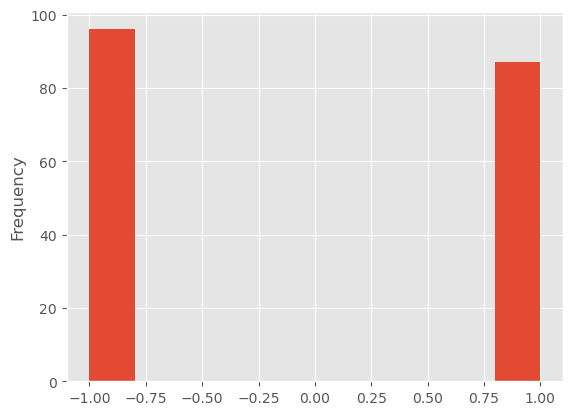

In [28]:
plt.style.use('ggplot')

daily_df['signal_daily'].plot(kind='hist')

plt.show()

<!-- @format -->

## 4. Merge with intraday data and calculate intraday indicators to form the intraday signal.

- Calculate all intraday indicators and intraday signal.


In [43]:
final_df = intraday_5min_df.reset_index()\
    .merge(daily_df[['signal_daily']].reset_index(),
           left_on='date',
           right_on='Date')\
    .drop(['date', 'Date'], axis=1)\
    .set_index('datetime')

final_df['rsi'] = pandas_ta.rsi(close=final_df['close'],
                                length=20)

final_df['lband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:, 0]

final_df['uband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:, 2]

final_df['signal_intraday'] = final_df.apply(lambda x: 1 if (x['rsi'] > 70) &
                                                            (x['close'] >
                                                             x['uband'])
                                             else (-1 if (x['rsi'] < 30) &
                                                         (x['close'] < x['lband']) else np.nan),
                                             axis=1)

final_df['return'] = np.log(final_df['close']).diff()

final_df

,open,low,high,close,volume,signal_daily,rsi,lband,uband,signal_intraday,return
datetime,,,,,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN,NaN,NaN,NaN,NaN,0.000018
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN,NaN,NaN,NaN,NaN,0.001269
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN,NaN,NaN,NaN,NaN,0.005589
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN,NaN,NaN,NaN,NaN,-0.000146
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18 23:35:00,6708.0025,6705.5175,6712.0000,6708.8675,11,NaN,62.861699,6677.365065,6715.855435,NaN,0.000128
2023-09-18 23:40:00,6708.8650,6707.1800,6714.2500,6709.3350,22,NaN,63.165869,6679.544207,6716.559793,NaN,0.000070
2023-09-18 23:45:00,6709.9250,6704.3600,6713.5000,6708.2750,25,NaN,61.954798,6682.379916,6716.534084,NaN,-0.000158


<!-- @format -->

## 5. Generate the position entry and hold until the end of the day.


In [55]:
final_df['return_sign'] = final_df.apply(lambda x: -1 if (x['signal_daily'] == 1) & (x['signal_intraday'] == 1)
                                         else (1 if (x['signal_daily'] == -1) & (x['signal_intraday'] == -1) else np.nan),
                                         axis=1)

final_df['return_sign'] = final_df.groupby(pd.Grouper(freq='D'))['return_sign']\
                                  .transform(lambda x: x.ffill())

final_df['forward_return'] = final_df['return'].shift(-1)

final_df['strategy_return'] = final_df['forward_return'] * \
    final_df['return_sign']

daily_return_df = final_df.groupby(pd.Grouper(freq='D'))[
    'strategy_return'].sum()

<!-- @format -->

## 6. Calculate final strategy returns.


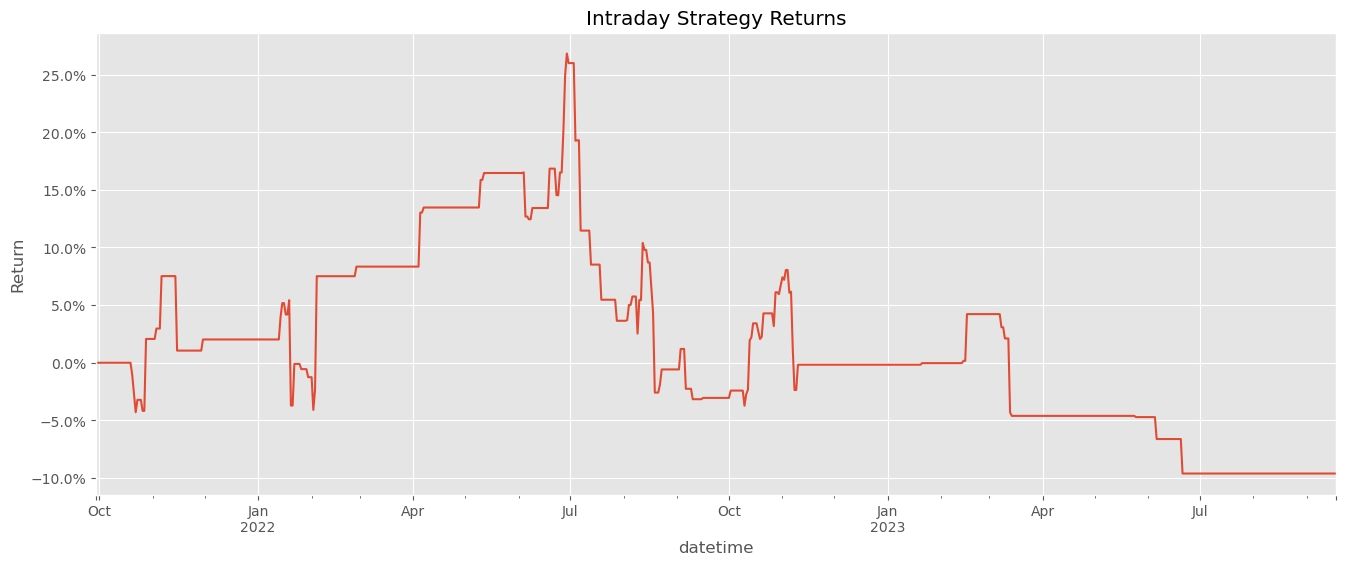

In [56]:
import matplotlib.ticker as mtick

strategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum()).sub(1)

strategy_cumulative_return.plot(figsize=(16, 6))

plt.title('Intraday Strategy Returns')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()